In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as  sns
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [42]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [43]:
genetic_selected_names = ['ptt_min','inr_max','calcium_min.1','temperature_mean','glucose_min','glucose_mean','weight_admit','aniongap_max','aniongap_min','potassium_min.1','bicarbonate_max.1','chloride_max.1','gcs_verbal','hemoglobin_min.1','hematocrit_min.1','bun_max','gcs_eyes','resp_rate_max','resp_rate_min','spo2_mean','spo2_min','dbp_min','sbp_mean','sbp_min','heart_rate_max','heart_rate_mean','race','admission_age']
genetic_selected_names.append('aki')
train = train.loc[:, genetic_selected_names]
test = test.loc[:, genetic_selected_names]

## Try

In [4]:
train.head()

,ptt_min,inr_max,calcium_min.1,temperature_mean,glucose_min,glucose_mean,weight_admit,aniongap_max,aniongap_min,potassium_min.1,bicarbonate_max.1,chloride_max.1,gcs_verbal,hemoglobin_min.1,hematocrit_min.1,bun_max,gcs_eyes,resp_rate_max,resp_rate_min,spo2_mean,spo2_min,dbp_min,sbp_mean,sbp_min,heart_rate_max,heart_rate_mean,race,admission_age,aki
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36570066,28.6,1.1,8.1,36.222000,76.0,146.2,110.0,20.0,15.0,4.8,28.0,101.0,5.0,9.2,27.8,52.0,4.0,24.0,13.0,98.916667,96.0,40.0,116.136364,103.0,104.0,100.083333,7,79.953141,3
39307659,28.4,2.3,7.9,36.558000,127.0,129.5,82.0,22.0,13.0,2.9,29.0,93.0,5.0,12.1,36.3,30.0,4.0,38.0,17.0,95.444444,91.0,56.0,109.833333,97.0,134.0,97.263158,32,78.194169,0
38743306,26.0,1.1,8.7,36.805000,207.0,254.0,62.1,12.0,12.0,3.8,27.0,102.0,5.0,9.5,31.1,8.0,4.0,19.0,14.0,97.166667,94.0,56.0,112.153846,95.0,97.0,84.166667,28,65.602396,2
32339865,26.1,1.2,8.3,37.087143,111.0,117.0,113.1,11.0,10.0,4.3,39.0,93.0,0.0,16.1,56.5,39.0,1.0,31.0,14.0,94.800000,89.0,60.0,138.160000,113.0,87.0,71.461538,27,64.906629,2
35526987,27.7,1.1,7.5,37.158750,158.0,187.0,97.4,16.0,13.0,4.2,22.0,109.0,0.0,14.0,44.0,23.0,1.0,32.0,18.0,95.951613,90.0,47.0,97.672131,81.0,100.0,82.387097,28,57.438861,2


In [44]:
def train_model(df):
    y = df['aki'].astype(float)
    X = df.drop(['aki'], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=20)
    lr = LogisticRegression(penalty='l2', fit_intercept=True, C=0.1, multi_class='multinomial')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("Accuracy:", accuracy)
    print(classification_report(y_valid, y_pred))
    return lr
    


In [45]:
lr = train_model(train)

Accuracy: 0.44516795865633074
              precision    recall  f1-score   support

         0.0       0.48      0.68      0.56      3157
         1.0       0.50      0.00      0.00      1904
         2.0       0.41      0.61      0.49      3059
         3.0       0.46      0.20      0.27      1555

    accuracy                           0.45      9675
   macro avg       0.46      0.37      0.33      9675
weighted avg       0.46      0.45      0.38      9675



In [46]:
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)
y_pred_proba = lr.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("LR AUC (Macro):", auc_macro)

LR AUC (Macro): 0.6434462187115005


In [16]:
def search_hyperparameter_LR(train, test, data_name='', param_dist=None):
    y = train['aki'].astype(float)
    X = train.drop(['aki'], axis=1)

    if param_dist is None:
        param_dist = {
            'C': np.logspace(-3, 3, 7),
            'penalty': ['l1', 'l2'],
            'multi_class': ['multinomial', 'ovr']
        }

    model = LogisticRegression()

    random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='accuracy', cv=5, n_iter=10, random_state=20, n_jobs=-1, verbose=2)
    random_search.fit(X, y)

    params = random_search.cv_results_['params']
    scores = random_search.cv_results_['mean_test_score']
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(scores)), scores, '-o')
    plt.ylabel('mean_test_score')
    plt.xticks(range(len(scores)), params, rotation=45)
    plt.title(f'{data_name} Randomized Search CV Results')
    plt.tight_layout()
    plt.show()

    print(f'best_params: {random_search.best_params_}')
    print(f'best_score: {random_search.best_score_}')

    best_model = random_search.best_estimator_
    y_test = test['aki'].astype(float)
    X_test = test.drop(['aki'], axis=1)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{data_name}最优模型在测试集上的表现:")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


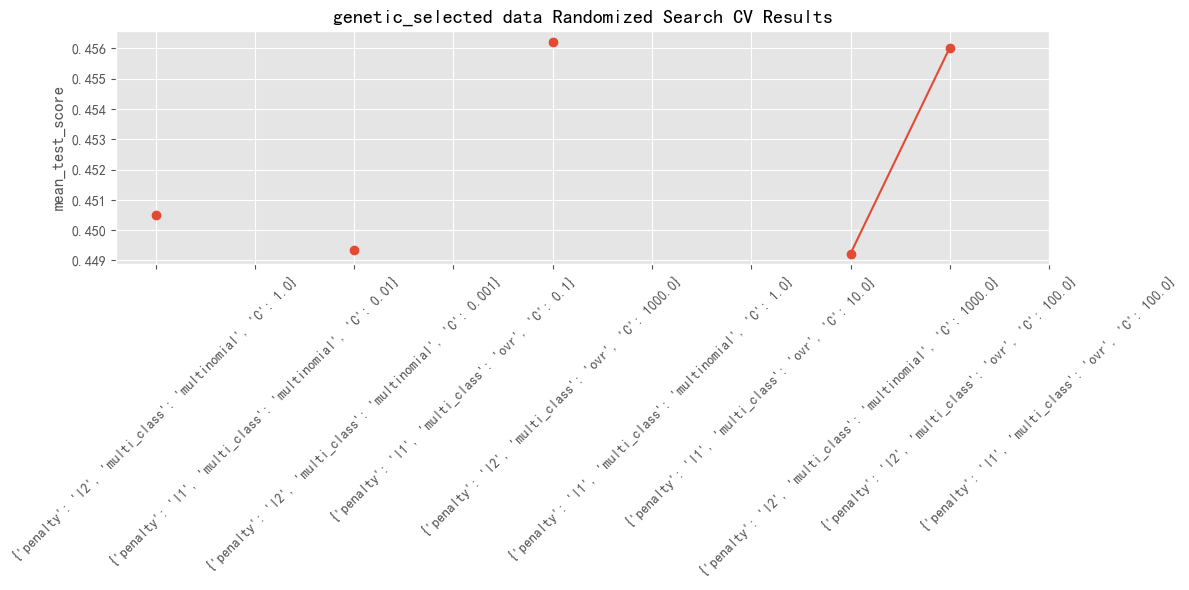

best_params: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 1000.0}
best_score: 0.4562162849995112
genetic_selected data最优模型在测试集上的表现:
Accuracy: 0.4512961508248233
              precision    recall  f1-score   support

         0.0       0.46      0.66      0.54       808
         1.0       0.00      0.00      0.00       461
         2.0       0.43      0.59      0.49       837
         3.0       0.55      0.28      0.37       440

    accuracy                           0.45      2546
   macro avg       0.36      0.38      0.35      2546
weighted avg       0.38      0.45      0.40      2546



In [24]:
search_hyperparameter_LR(train, test, "genetic_selected data")

## Feature engineering

### StandardScaler

In [4]:
cols = ['ptt_min', 'inr_max', 'calcium_min.1', 'temperature_mean',
       'glucose_min', 'glucose_mean', 'weight_admit', 'aniongap_max',
       'aniongap_min', 'potassium_min.1', 'bicarbonate_max.1',
       'chloride_max.1', 'gcs_verbal', 'hemoglobin_min.1', 'hematocrit_min.1',
       'bun_max', 'gcs_eyes', 'resp_rate_max', 'resp_rate_min', 'spo2_mean',
       'spo2_min', 'dbp_min', 'sbp_mean', 'sbp_min', 'heart_rate_max',
       'heart_rate_mean', 'race', 'admission_age']
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[cols])
scaled_train = pd.DataFrame(scaled_train, columns=cols, index=train.index)
scaled_train = pd.concat([scaled_train, train["aki"]], axis=1)
scaled_test = scaler.transform(test[cols])
scaled_test = pd.DataFrame(scaled_test, columns=cols, index=test.index)
scaled_test = pd.concat([scaled_test, test["aki"]], axis=1)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


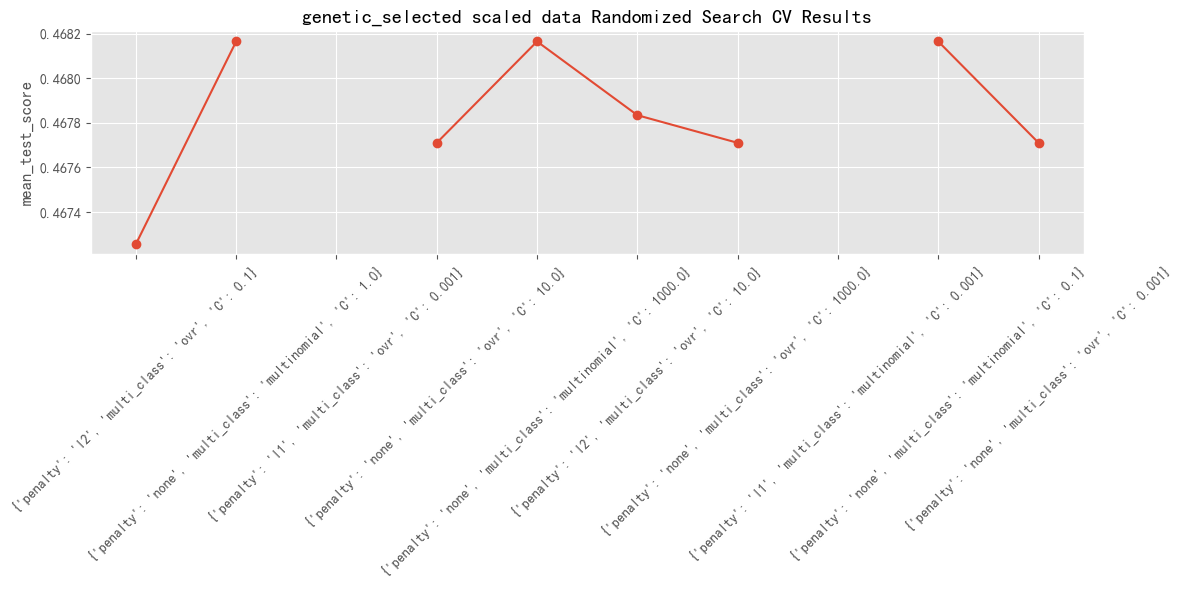

best_params: {'penalty': 'none', 'multi_class': 'multinomial', 'C': 1.0}
best_score: 0.46816480413949535
genetic_selected scaled data最优模型在测试集上的表现:
Accuracy: 0.45286724273369994
              precision    recall  f1-score   support

         0.0       0.47      0.66      0.55       808
         1.0       0.00      0.00      0.00       461
         2.0       0.42      0.58      0.49       837
         3.0       0.53      0.30      0.38       440

    accuracy                           0.45      2546
   macro avg       0.36      0.39      0.35      2546
weighted avg       0.38      0.45      0.40      2546



In [38]:
search_hyperparameter_LR(scaled_train, scaled_test, "genetic_selected scaled data", {
            'C': np.logspace(-3, 3, 7),
            'penalty': ['none', 'l1', 'l2'],
            'multi_class': ['multinomial', 'ovr']
        })

### Feature discretization

In [5]:
def get_best_bin(df, feature_name):
    data = pd.DataFrame(df['aki'])
    max_bins = 20
    number_of_bins = []
    chi_square_stats = []
    for num_bins in range(2, max_bins+1):
        data["bin"] = pd.cut(df[feature_name], bins=num_bins)

        observed = pd.crosstab(data["bin"], data["aki"])
        chi2, p, _, _ = stats.chi2_contingency(observed)
        print(f"Number of bins: {num_bins}, Chi-square statistic: {chi2}, p-value: {p}")
        number_of_bins.append(num_bins)
        chi_square_stats.append(chi2)

    plt.plot(number_of_bins, chi_square_stats)
    plt.xlabel('Number of bins')
    plt.ylabel('Chi-square statistic')
    plt.title(f'{feature_name}')
    plt.show()


Number of bins: 2, Chi-square statistic: 21.91638848043811, p-value: 6.789700989324417e-05
Number of bins: 3, Chi-square statistic: 195.66368338284096, p-value: 1.5884708148150688e-39
Number of bins: 4, Chi-square statistic: 749.6619196703649, p-value: 1.4448596656883736e-155
Number of bins: 5, Chi-square statistic: 1027.9730002414776, p-value: 1.812648686296003e-212
Number of bins: 6, Chi-square statistic: 775.6647644210299, p-value: 1.3424904421584216e-155
Number of bins: 7, Chi-square statistic: 866.6723497560306, p-value: 2.0028249488956557e-172
Number of bins: 8, Chi-square statistic: 1173.2683339301889, p-value: 3.0216897354286722e-235
Number of bins: 9, Chi-square statistic: 1351.8800837667434, p-value: 9.50427137044638e-271
Number of bins: 10, Chi-square statistic: 1421.7158441503475, p-value: 5.013857742500788e-283
Number of bins: 11, Chi-square statistic: 1150.1256253750641, p-value: 9.113472430734799e-223
Number of bins: 12, Chi-square statistic: 1154.1428846868776, p-value:

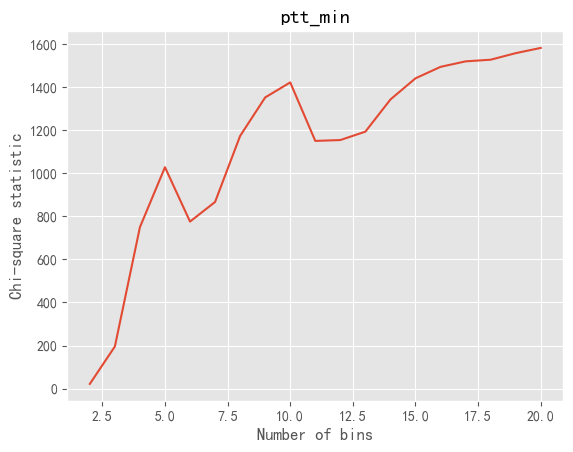

Number of bins: 2, Chi-square statistic: 11.019989902708758, p-value: 0.011618272240406175
Number of bins: 3, Chi-square statistic: 43.09108729812985, p-value: 1.1190107945625624e-07
Number of bins: 4, Chi-square statistic: 457.46230182138504, p-value: 7.277543897236962e-93
Number of bins: 5, Chi-square statistic: 459.41513833676015, p-value: 9.451060214655137e-91
Number of bins: 6, Chi-square statistic: 421.2758443249999, p-value: 2.3201356464642034e-80
Number of bins: 7, Chi-square statistic: 361.8472450332516, p-value: 7.940300269977177e-66
Number of bins: 8, Chi-square statistic: 755.3634546148169, p-value: 2.595993098902938e-146
Number of bins: 9, Chi-square statistic: 802.3600056306828, p-value: 6.566862340905287e-154
Number of bins: 10, Chi-square statistic: 836.2237345475685, p-value: 9.17264648840176e-159
Number of bins: 11, Chi-square statistic: 956.1764823815673, p-value: 9.005314794897647e-182
Number of bins: 12, Chi-square statistic: 1143.32196038817, p-value: 5.7967880940

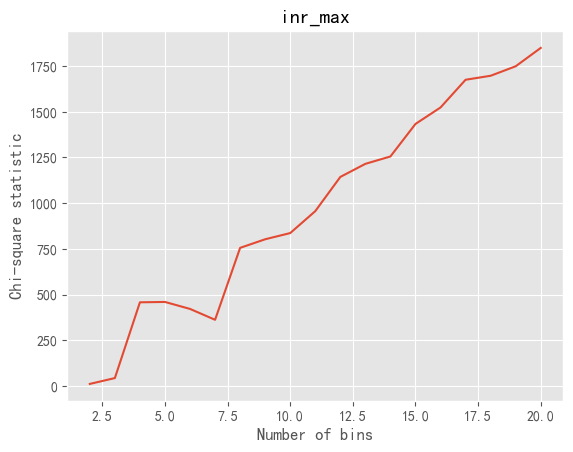

Number of bins: 2, Chi-square statistic: 10.195688053259625, p-value: 0.01697390124162791
Number of bins: 3, Chi-square statistic: 100.34056232684506, p-value: 2.1305669072365169e-19
Number of bins: 4, Chi-square statistic: 241.96553010219242, p-value: 4.947455111743777e-47
Number of bins: 5, Chi-square statistic: 495.25072143316277, p-value: 2.2713756659531513e-98
Number of bins: 6, Chi-square statistic: 190.7042990145467, p-value: 1.632737749233063e-32
Number of bins: 7, Chi-square statistic: 196.16168122897514, p-value: 5.857587886454078e-32
Number of bins: 8, Chi-square statistic: 708.9103482067586, p-value: 1.7391375456278158e-136
Number of bins: 9, Chi-square statistic: 960.8750592989695, p-value: 1.8010259406395782e-187
Number of bins: 10, Chi-square statistic: 788.8438585910709, p-value: 8.611155086445098e-149
Number of bins: 11, Chi-square statistic: 906.4407044821445, p-value: 2.6941440841586702e-171
Number of bins: 12, Chi-square statistic: 993.4201889583471, p-value: 2.3426

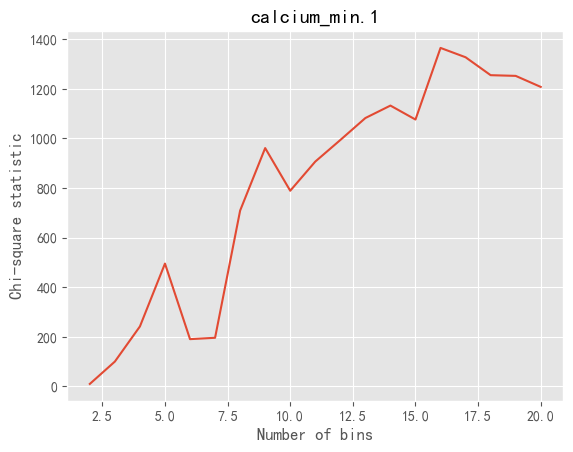

Number of bins: 2, Chi-square statistic: 120.79279458968425, p-value: 5.208231187398556e-26
Number of bins: 3, Chi-square statistic: 258.16783757369234, p-value: 7.362227949414909e-53
Number of bins: 4, Chi-square statistic: 207.56053888554996, p-value: 8.596276456733367e-40
Number of bins: 5, Chi-square statistic: 323.7799925173739, p-value: 4.7046189770908065e-62
Number of bins: 6, Chi-square statistic: 342.0039972241009, p-value: 9.86001334620637e-64
Number of bins: 7, Chi-square statistic: 432.2892478704075, p-value: 1.6531693823264301e-80
Number of bins: 8, Chi-square statistic: 310.6082708882252, p-value: 2.194800064920277e-53
Number of bins: 9, Chi-square statistic: 465.10553664548615, p-value: 2.851969174371192e-83
Number of bins: 10, Chi-square statistic: 561.1711773634565, p-value: 3.393339689459822e-101
Number of bins: 11, Chi-square statistic: 551.3512017353306, p-value: 3.3367451199425946e-97
Number of bins: 12, Chi-square statistic: 444.15724652068855, p-value: 3.09960183

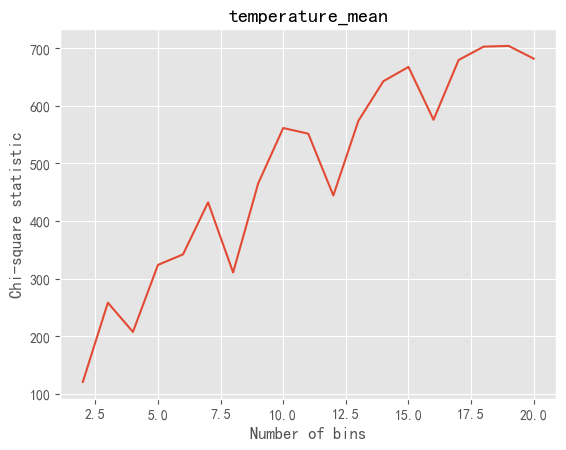

Number of bins: 2, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 3, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 4, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 5, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 6, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 7, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 8, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 9, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 10, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 11, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 12, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 13

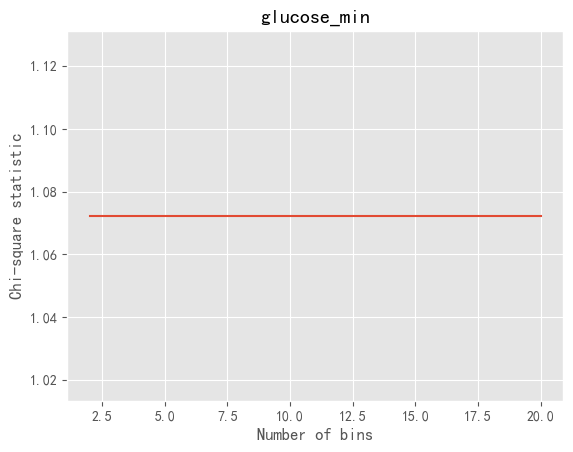

Number of bins: 2, Chi-square statistic: 0.43016580770364227, p-value: 0.9339428115258928
Number of bins: 3, Chi-square statistic: 4.931959491969136, p-value: 0.5525690533384189
Number of bins: 4, Chi-square statistic: 6.3135583896861345, p-value: 0.708171987558335
Number of bins: 5, Chi-square statistic: 12.112033693226897, p-value: 0.20706683308111923
Number of bins: 6, Chi-square statistic: 17.621809005040312, p-value: 0.12766549795313514
Number of bins: 7, Chi-square statistic: 20.386787501531963, p-value: 0.06011396458347986
Number of bins: 8, Chi-square statistic: 17.58865329366167, p-value: 0.1287631862271209
Number of bins: 9, Chi-square statistic: 22.321677947208332, p-value: 0.03406879071192475
Number of bins: 10, Chi-square statistic: 33.235259683001296, p-value: 0.0043544381662368944
Number of bins: 11, Chi-square statistic: 33.235259683001296, p-value: 0.0043544381662368944
Number of bins: 12, Chi-square statistic: 30.05554133463135, p-value: 0.011722788030043164
Number of

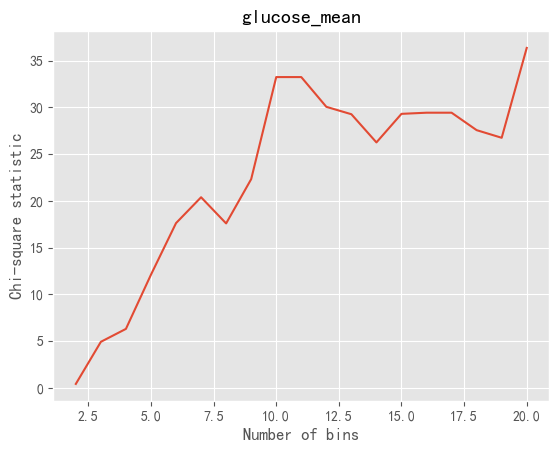

Number of bins: 2, Chi-square statistic: 5.455143461374299, p-value: 0.14134628747330286
Number of bins: 3, Chi-square statistic: 5.455143461374299, p-value: 0.14134628747330286
Number of bins: 4, Chi-square statistic: 5.455143461374299, p-value: 0.14134628747330286
Number of bins: 5, Chi-square statistic: 9.613980883552141, p-value: 0.14187782815031547
Number of bins: 6, Chi-square statistic: 9.26239681434436, p-value: 0.15934993355045704
Number of bins: 7, Chi-square statistic: 9.26239681434436, p-value: 0.15934993355045704
Number of bins: 8, Chi-square statistic: 7.33120411567352, p-value: 0.2913004378437687
Number of bins: 9, Chi-square statistic: 5.487057799410124, p-value: 0.48302232407117474
Number of bins: 10, Chi-square statistic: 10.820470342527322, p-value: 0.2882158597027516
Number of bins: 11, Chi-square statistic: 11.395065812754936, p-value: 0.24959782306938624
Number of bins: 12, Chi-square statistic: 11.043500596745657, p-value: 0.2727389777726947
Number of bins: 13, C

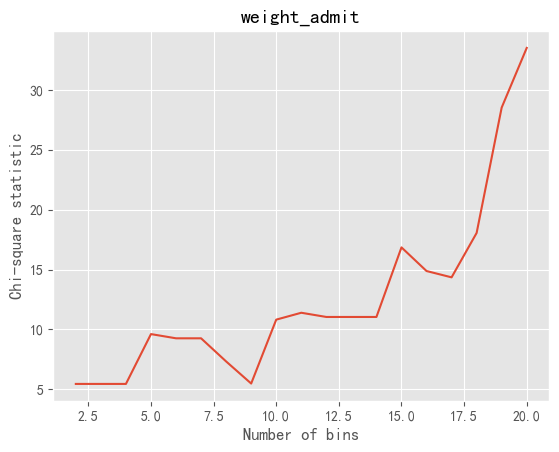

Number of bins: 2, Chi-square statistic: 61.14056523883753, p-value: 3.3537938023836243e-13
Number of bins: 3, Chi-square statistic: 335.94933165359174, p-value: 1.6001398418307282e-69
Number of bins: 4, Chi-square statistic: 772.3369592597712, p-value: 1.9106390193882862e-160
Number of bins: 5, Chi-square statistic: 1467.891048048501, p-value: 3.1886838438159124e-307
Number of bins: 6, Chi-square statistic: 1821.1689338246065, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1649.9677180940548, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1399.0882725406195, p-value: 2.23784593924674e-286
Number of bins: 9, Chi-square statistic: 1494.5655042500446, p-value: 7.018616615194775e-307
Number of bins: 10, Chi-square statistic: 1728.0589671481316, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1895.5675185656596, p-value: 0.0
Number of bins: 12, Chi-square statistic: 2036.01725108427, p-value: 0.0
Number of bins: 13, Chi-square statistic: 2017.2596147926606, p-value: 0.

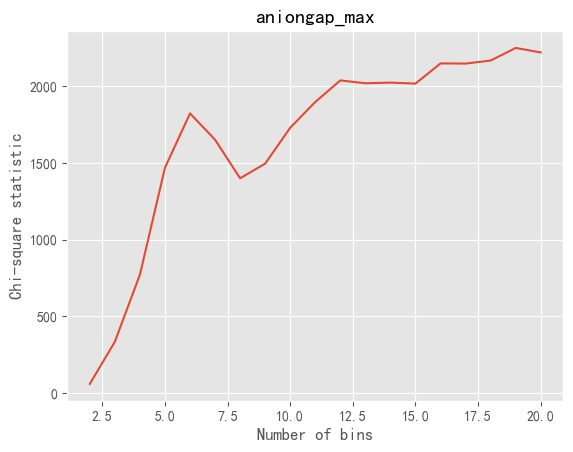

Number of bins: 2, Chi-square statistic: 822.9568160760975, p-value: 4.5431106822285273e-178
Number of bins: 3, Chi-square statistic: 446.9279214456527, p-value: 2.249607864076919e-93
Number of bins: 4, Chi-square statistic: 1049.3409263330832, p-value: 3.938883886825582e-220
Number of bins: 5, Chi-square statistic: 1213.0816348306964, p-value: 2.638625845592472e-252
Number of bins: 6, Chi-square statistic: 1107.8939514773142, p-value: 9.759158675737898e-227
Number of bins: 7, Chi-square statistic: 1462.9915961201718, p-value: 4.2496653639022594e-300
Number of bins: 8, Chi-square statistic: 1513.9865112860618, p-value: 3.503653052670081e-308
Number of bins: 9, Chi-square statistic: 1596.9082226450596, p-value: 0.0
Number of bins: 10, Chi-square statistic: 1593.8917173970135, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1825.5947204715405, p-value: 0.0
Number of bins: 12, Chi-square statistic: 1949.9423519076322, p-value: 0.0
Number of bins: 13, Chi-square statistic: 1892.9989

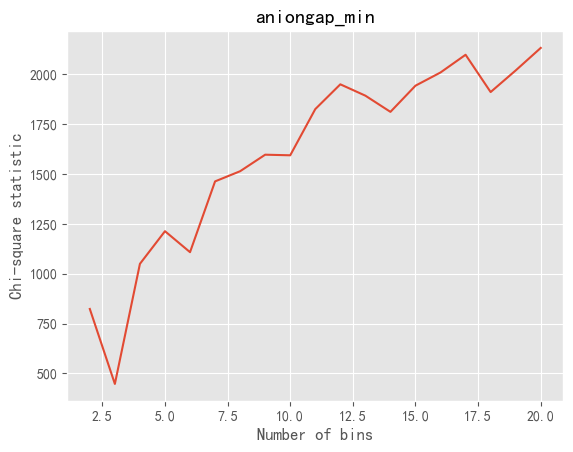

Number of bins: 2, Chi-square statistic: 273.01843310413295, p-value: 6.861493166389834e-59
Number of bins: 3, Chi-square statistic: 78.90267045404367, p-value: 6.020102201518355e-15
Number of bins: 4, Chi-square statistic: 321.3126555201559, p-value: 7.804529957068511e-64
Number of bins: 5, Chi-square statistic: 563.3558606625105, p-value: 7.017173036826018e-113
Number of bins: 6, Chi-square statistic: 390.07419829083324, p-value: 8.408820989964593e-74
Number of bins: 7, Chi-square statistic: 657.4017379500724, p-value: 6.11758272964595e-128
Number of bins: 8, Chi-square statistic: 663.3454738203911, p-value: 7.266885293536841e-127
Number of bins: 9, Chi-square statistic: 601.9049280650437, p-value: 9.471994956440915e-112
Number of bins: 10, Chi-square statistic: 741.6384160713924, p-value: 7.104087094227821e-139
Number of bins: 11, Chi-square statistic: 684.4257898227103, p-value: 8.642782446672419e-125
Number of bins: 12, Chi-square statistic: 805.0812996637835, p-value: 7.164886217

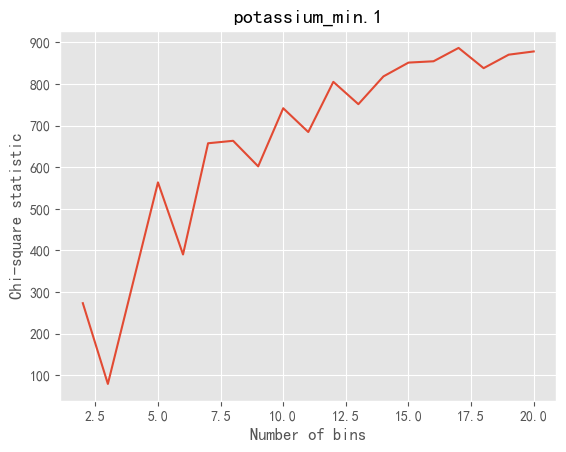

Number of bins: 2, Chi-square statistic: 44.042755250676166, p-value: 1.4779490360901312e-09
Number of bins: 3, Chi-square statistic: 898.4603350146598, p-value: 8.084598871522944e-191
Number of bins: 4, Chi-square statistic: 431.613626952431, p-value: 2.437492829616492e-87
Number of bins: 5, Chi-square statistic: 647.6665537687921, p-value: 6.920819533627246e-131
Number of bins: 6, Chi-square statistic: 983.5757060420851, p-value: 4.4610642459768316e-200
Number of bins: 7, Chi-square statistic: 896.9578510981177, p-value: 6.987024419211524e-179
Number of bins: 8, Chi-square statistic: 1093.5344509350552, p-value: 3.194448394865937e-218
Number of bins: 9, Chi-square statistic: 1137.1350705751822, p-value: 6.083773356601345e-225
Number of bins: 10, Chi-square statistic: 1180.6112852483077, p-value: 1.1171812746679023e-231
Number of bins: 11, Chi-square statistic: 1229.0808957477677, p-value: 1.6510653148973473e-239
Number of bins: 12, Chi-square statistic: 1211.0891652863088, p-value: 2

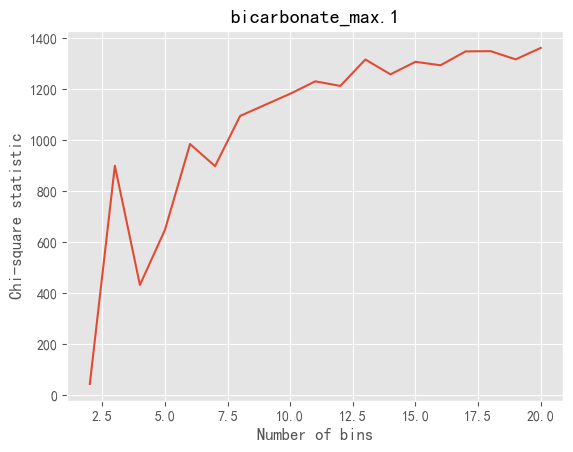

Number of bins: 2, Chi-square statistic: 82.92985234189004, p-value: 7.21858670300729e-18
Number of bins: 3, Chi-square statistic: 165.39877803183214, p-value: 4.2519511040519416e-33
Number of bins: 4, Chi-square statistic: 253.46956027717238, p-value: 1.8464582642923837e-49
Number of bins: 5, Chi-square statistic: 956.475942838788, p-value: 4.2411323379627694e-197
Number of bins: 6, Chi-square statistic: 446.56381963313845, p-value: 1.0916535743617485e-85
Number of bins: 7, Chi-square statistic: 615.6860045782341, p-value: 4.1494789375329367e-119
Number of bins: 8, Chi-square statistic: 779.2571612521772, p-value: 2.2594117315314272e-151
Number of bins: 9, Chi-square statistic: 873.6721321700621, p-value: 5.468956575732852e-169
Number of bins: 10, Chi-square statistic: 1033.0270703833473, p-value: 2.3551991469654906e-200
Number of bins: 11, Chi-square statistic: 1008.2814523295494, p-value: 9.161928931273073e-193
Number of bins: 12, Chi-square statistic: 910.9557462705202, p-value: 4.

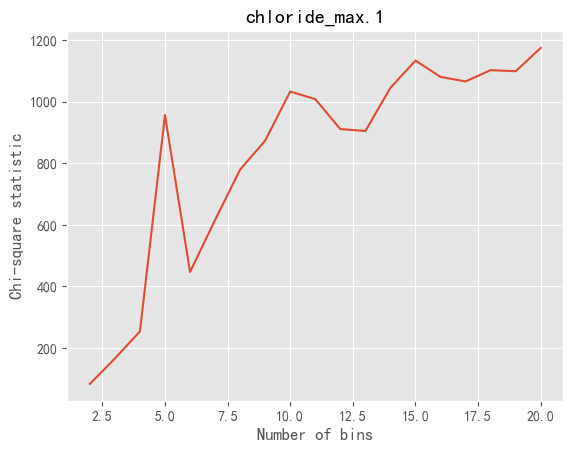

Number of bins: 2, Chi-square statistic: 1708.334296326125, p-value: 0.0
Number of bins: 3, Chi-square statistic: 1717.5128130643368, p-value: 0.0
Number of bins: 4, Chi-square statistic: 1737.221326207386, p-value: 0.0
Number of bins: 5, Chi-square statistic: 2053.625596284179, p-value: 0.0
Number of bins: 6, Chi-square statistic: 2053.4274287866883, p-value: 0.0
Number of bins: 7, Chi-square statistic: 2054.0674497248315, p-value: 0.0
Number of bins: 8, Chi-square statistic: 2060.903895584105, p-value: 0.0
Number of bins: 9, Chi-square statistic: 2136.8782997828257, p-value: 0.0
Number of bins: 10, Chi-square statistic: 2161.010754637452, p-value: 0.0
Number of bins: 11, Chi-square statistic: 2093.8455855159546, p-value: 0.0
Number of bins: 12, Chi-square statistic: 2121.0712940809917, p-value: 0.0
Number of bins: 13, Chi-square statistic: 2191.179444619366, p-value: 0.0
Number of bins: 14, Chi-square statistic: 2197.94065297197, p-value: 0.0
Number of bins: 15, Chi-square statistic:

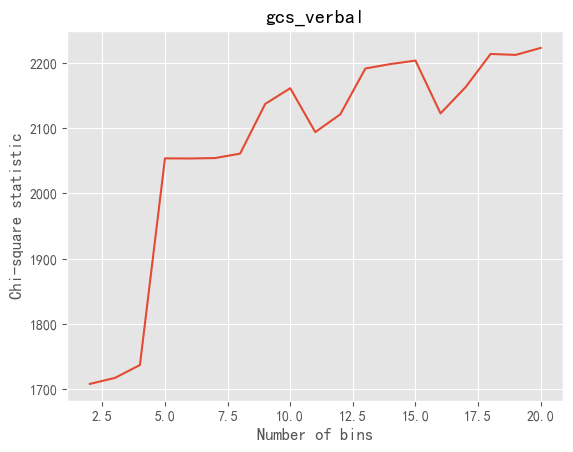

Number of bins: 2, Chi-square statistic: 987.6094229177278, p-value: 8.770218768568508e-214
Number of bins: 3, Chi-square statistic: 599.3712686183189, p-value: 3.1870059976569136e-126
Number of bins: 4, Chi-square statistic: 1024.8174917739802, p-value: 7.668202461599359e-215
Number of bins: 5, Chi-square statistic: 1064.3243546622894, p-value: 2.754442184501807e-220
Number of bins: 6, Chi-square statistic: 1212.7143430710466, p-value: 3.0387973649749873e-249
Number of bins: 7, Chi-square statistic: 1175.7113343289695, p-value: 1.786953503152611e-238
Number of bins: 8, Chi-square statistic: 1235.5909116850564, p-value: 1.4462712091911074e-248
Number of bins: 9, Chi-square statistic: 1312.5950292457262, p-value: 2.3328825838785717e-262
Number of bins: 10, Chi-square statistic: 1310.9773088520446, p-value: 2.0284961682511057e-259
Number of bins: 11, Chi-square statistic: 1310.9784912259756, p-value: 6.691273546754136e-257
Number of bins: 12, Chi-square statistic: 1369.375532714241, p-va

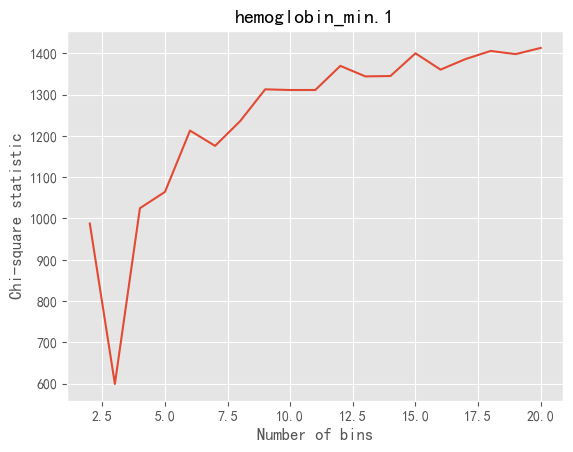

Number of bins: 2, Chi-square statistic: 564.1296743801815, p-value: 6.014437490506709e-122
Number of bins: 3, Chi-square statistic: 552.0974264970757, p-value: 4.9848837744331365e-116
Number of bins: 4, Chi-square statistic: 676.195111829124, p-value: 9.049107540521823e-140
Number of bins: 5, Chi-square statistic: 758.7504376049351, p-value: 1.151717344771755e-154
Number of bins: 6, Chi-square statistic: 891.5999220888399, p-value: 2.214004730313578e-180
Number of bins: 7, Chi-square statistic: 967.541404351476, p-value: 6.023877158996554e-194
Number of bins: 8, Chi-square statistic: 937.910614670602, p-value: 4.62997566362051e-185
Number of bins: 9, Chi-square statistic: 958.1911664213984, p-value: 6.683222869267298e-187
Number of bins: 10, Chi-square statistic: 1034.7229401942093, p-value: 1.0295828393471253e-200
Number of bins: 11, Chi-square statistic: 1005.7059303684371, p-value: 3.2043157289315963e-192
Number of bins: 12, Chi-square statistic: 1071.3081167916412, p-value: 9.1974

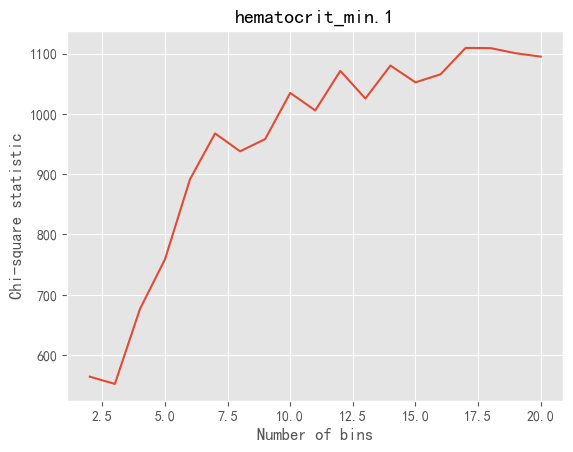

Number of bins: 2, Chi-square statistic: 174.91348842803424, p-value: 1.1061964367030513e-37
Number of bins: 3, Chi-square statistic: 1024.6022474452952, p-value: 4.267415959821839e-218
Number of bins: 4, Chi-square statistic: 1718.5171485288438, p-value: 0.0
Number of bins: 5, Chi-square statistic: 2431.3077874809965, p-value: 0.0
Number of bins: 6, Chi-square statistic: 3032.641597190892, p-value: 0.0
Number of bins: 7, Chi-square statistic: 3576.912467323176, p-value: 0.0
Number of bins: 8, Chi-square statistic: 3952.124081854041, p-value: 0.0
Number of bins: 9, Chi-square statistic: 4184.8925979771575, p-value: 0.0
Number of bins: 10, Chi-square statistic: 4451.029916252322, p-value: 0.0
Number of bins: 11, Chi-square statistic: 4528.000395435452, p-value: 0.0
Number of bins: 12, Chi-square statistic: 4788.262232439707, p-value: 0.0
Number of bins: 13, Chi-square statistic: 4930.221790496677, p-value: 0.0
Number of bins: 14, Chi-square statistic: 5062.377138967626, p-value: 0.0
Num

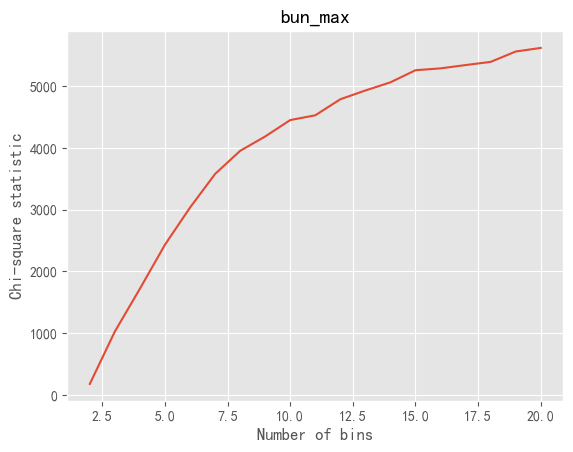

Number of bins: 2, Chi-square statistic: 1017.4132253689418, p-value: 3.0035868078644975e-220
Number of bins: 3, Chi-square statistic: 1370.8278411632416, p-value: 5.019489646776971e-293
Number of bins: 4, Chi-square statistic: 1382.4944586794106, p-value: 4.681841171647687e-292
Number of bins: 5, Chi-square statistic: 1465.025861486606, p-value: 1.3229455634002517e-306
Number of bins: 6, Chi-square statistic: 1515.8065725312288, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1459.910582566959, p-value: 1.9501761206955376e-299
Number of bins: 8, Chi-square statistic: 1499.2411083097563, p-value: 5.082985023510168e-305
Number of bins: 9, Chi-square statistic: 1536.657405894872, p-value: 2.91877267969873e-310
Number of bins: 10, Chi-square statistic: 1507.3516537849255, p-value: 2.6404277476065138e-301
Number of bins: 11, Chi-square statistic: 1525.33046404774, p-value: 1.581250166280798e-302
Number of bins: 12, Chi-square statistic: 1554.329677399257, p-value: 3.7854994224116115e

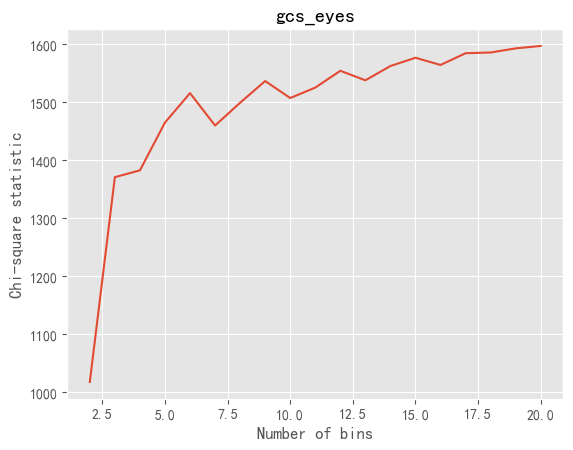

Number of bins: 2, Chi-square statistic: 167.6676311023541, p-value: 4.0566600173543265e-36
Number of bins: 3, Chi-square statistic: 678.3022056284163, p-value: 2.957093392882587e-143
Number of bins: 4, Chi-square statistic: 516.6067007229777, p-value: 1.595852849035326e-105
Number of bins: 5, Chi-square statistic: 650.0690058965835, p-value: 2.1207360198547916e-131
Number of bins: 6, Chi-square statistic: 769.1443306117685, p-value: 3.3115964621530355e-154
Number of bins: 7, Chi-square statistic: 824.7874588731473, p-value: 1.67935045872126e-163
Number of bins: 8, Chi-square statistic: 833.7348685759575, p-value: 6.344605589826617e-163
Number of bins: 9, Chi-square statistic: 924.6071471636748, p-value: 8.863151976877787e-180
Number of bins: 10, Chi-square statistic: 906.0547370566535, p-value: 1.7110359506432364e-173
Number of bins: 11, Chi-square statistic: 946.4195609236543, p-value: 1.0255599696072843e-179
Number of bins: 12, Chi-square statistic: 928.9918671949924, p-value: 8.123

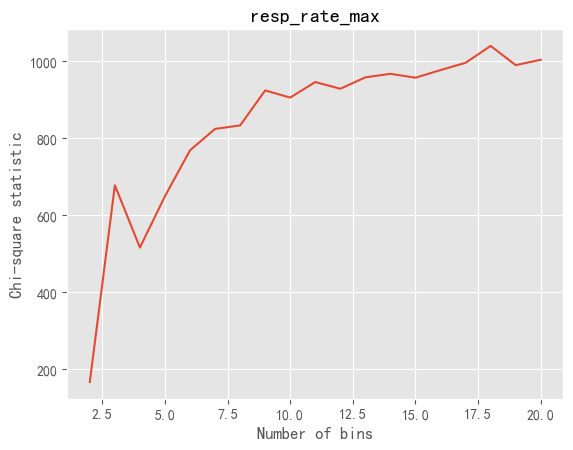

Number of bins: 2, Chi-square statistic: 19.55857085085064, p-value: 0.00020952098582545674
Number of bins: 3, Chi-square statistic: 175.88655264692775, p-value: 2.534962373842467e-35
Number of bins: 4, Chi-square statistic: 131.381351547587, p-value: 6.164801587248721e-24
Number of bins: 5, Chi-square statistic: 150.55518662656348, p-value: 4.37447751866704e-26
Number of bins: 6, Chi-square statistic: 268.47690360051786, p-value: 1.9117604810465426e-48
Number of bins: 7, Chi-square statistic: 355.04191883394316, p-value: 2.051210766676621e-64
Number of bins: 8, Chi-square statistic: 313.7979188068199, p-value: 4.905013192162846e-54
Number of bins: 9, Chi-square statistic: 309.3499321737947, p-value: 2.186710517084977e-51
Number of bins: 10, Chi-square statistic: 369.7683874941713, p-value: 1.1669180826108764e-63
Number of bins: 11, Chi-square statistic: 401.2033411418404, p-value: 2.842102051383201e-68
Number of bins: 12, Chi-square statistic: 386.61127645774894, p-value: 1.4057454235

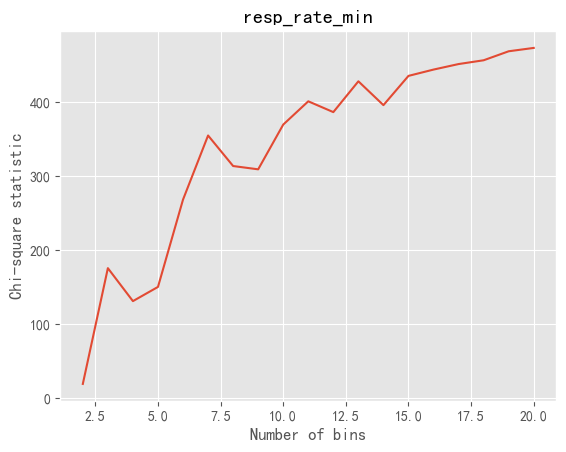

Number of bins: 2, Chi-square statistic: 44.98384543297063, p-value: 9.32613690337433e-10
Number of bins: 3, Chi-square statistic: 62.81672395259399, p-value: 1.202871326386973e-11
Number of bins: 4, Chi-square statistic: 81.4832182878755, p-value: 8.196102897122855e-14
Number of bins: 5, Chi-square statistic: 112.09999141257393, p-value: 2.2975967394670653e-18
Number of bins: 6, Chi-square statistic: 96.35076028192006, p-value: 6.387556868917164e-14
Number of bins: 7, Chi-square statistic: 109.32058419126322, p-value: 4.211117410177512e-15
Number of bins: 8, Chi-square statistic: 121.02938020468251, p-value: 4.621645211310911e-16
Number of bins: 9, Chi-square statistic: 133.09035300134383, p-value: 4.264916304885873e-17
Number of bins: 10, Chi-square statistic: 216.74365392766782, p-value: 1.5512553946146666e-31
Number of bins: 11, Chi-square statistic: 217.32746887139774, p-value: 2.703678277089085e-30
Number of bins: 12, Chi-square statistic: 220.56717781040675, p-value: 1.297908967

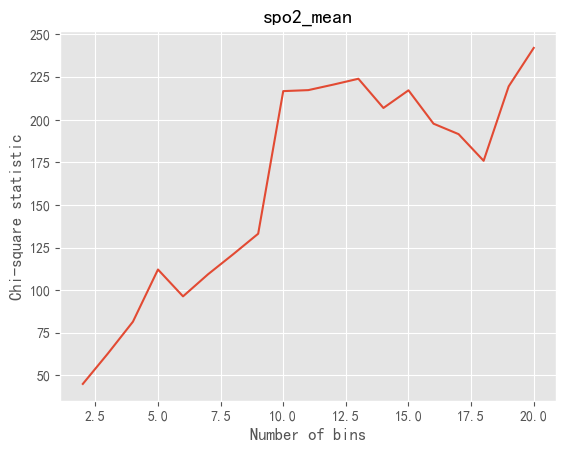

Number of bins: 2, Chi-square statistic: 54.04706665811429, p-value: 1.0964231888400253e-11
Number of bins: 3, Chi-square statistic: 83.24131495561134, p-value: 7.63532333797445e-16
Number of bins: 4, Chi-square statistic: 200.79145304125842, p-value: 2.2610027681923053e-38
Number of bins: 5, Chi-square statistic: 244.9925143385542, p-value: 1.5133122498036295e-45
Number of bins: 6, Chi-square statistic: 356.2109604513731, p-value: 1.0546143715264083e-66
Number of bins: 7, Chi-square statistic: 456.59073158011955, p-value: 1.350390731071624e-85
Number of bins: 8, Chi-square statistic: 625.4760257590508, p-value: 6.963682656842903e-119
Number of bins: 9, Chi-square statistic: 838.4145314933718, p-value: 1.576443296690088e-161
Number of bins: 10, Chi-square statistic: 893.4666661572373, p-value: 7.77939514556169e-171
Number of bins: 11, Chi-square statistic: 918.2175441299235, p-value: 8.941749699583364e-174
Number of bins: 12, Chi-square statistic: 959.1932358240896, p-value: 3.68539803

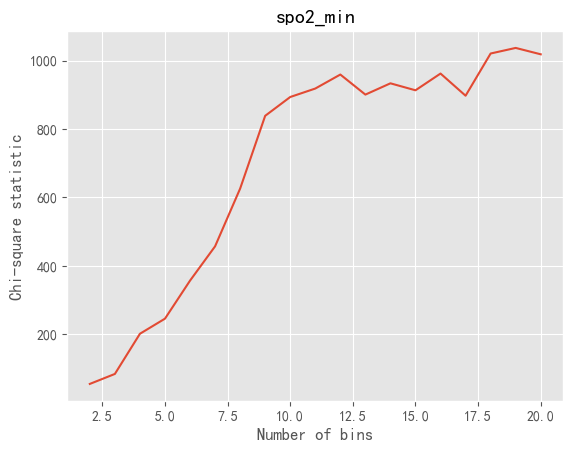

Number of bins: 2, Chi-square statistic: 898.2990136178222, p-value: 2.0700499481477565e-194
Number of bins: 3, Chi-square statistic: 962.4101269054634, p-value: 1.2042916731619552e-204
Number of bins: 4, Chi-square statistic: 1195.0338095252202, p-value: 1.431640423129977e-251
Number of bins: 5, Chi-square statistic: 1491.054691562092, p-value: 0.0
Number of bins: 6, Chi-square statistic: 1537.0999169848933, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1727.2818641038943, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1758.2106303582977, p-value: 0.0
Number of bins: 9, Chi-square statistic: 1814.2114190319362, p-value: 0.0
Number of bins: 10, Chi-square statistic: 1837.033182943798, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1934.1003918740303, p-value: 0.0
Number of bins: 12, Chi-square statistic: 1921.578428912924, p-value: 0.0
Number of bins: 13, Chi-square statistic: 1938.7780619977502, p-value: 0.0
Number of bins: 14, Chi-square statistic: 1989.8907461

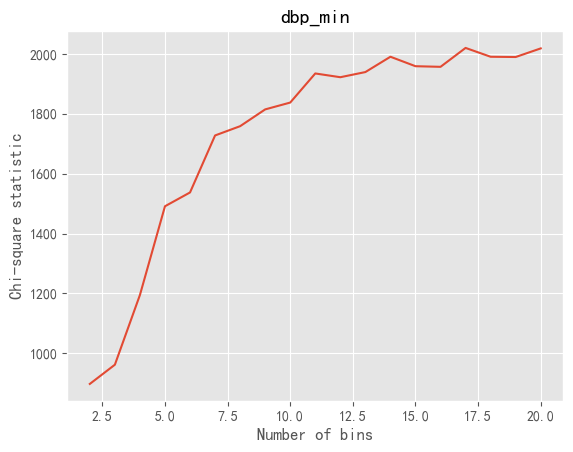

Number of bins: 2, Chi-square statistic: 262.96718340964003, p-value: 1.0254977168479206e-56
Number of bins: 3, Chi-square statistic: 142.83655911405708, p-value: 2.524553013182164e-28
Number of bins: 4, Chi-square statistic: 347.6362254518665, p-value: 1.9734383110970874e-69
Number of bins: 5, Chi-square statistic: 567.735905879086, p-value: 8.162159362271123e-114
Number of bins: 6, Chi-square statistic: 446.9860548072062, p-value: 8.893102832753959e-86
Number of bins: 7, Chi-square statistic: 611.9857332981171, p-value: 2.5154922536042015e-118
Number of bins: 8, Chi-square statistic: 643.1970998114235, p-value: 1.2872171319976142e-122
Number of bins: 9, Chi-square statistic: 650.087228509028, p-value: 7.593776427564048e-122
Number of bins: 10, Chi-square statistic: 709.9324616366091, p-value: 3.16120165470804e-132
Number of bins: 11, Chi-square statistic: 738.7164874924412, p-value: 4.077061196477166e-136
Number of bins: 12, Chi-square statistic: 758.8826437164347, p-value: 3.0928929

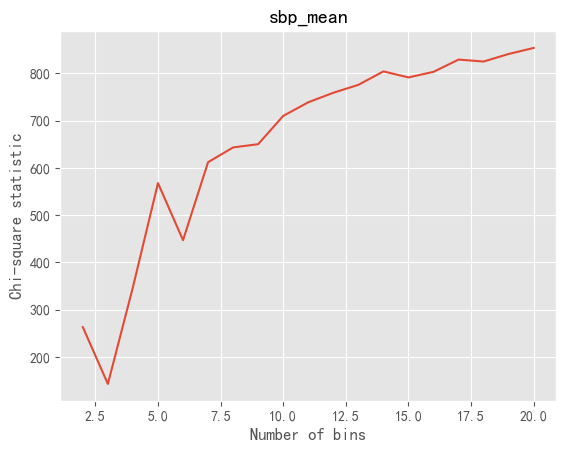

Number of bins: 2, Chi-square statistic: 1236.3949165357863, p-value: 9.303034854310945e-268
Number of bins: 3, Chi-square statistic: 542.2729063440333, p-value: 6.53858619975951e-114
Number of bins: 4, Chi-square statistic: 1311.0837875501184, p-value: 1.2489688051000373e-276
Number of bins: 5, Chi-square statistic: 1453.9221730381528, p-value: 3.282308223557433e-304
Number of bins: 6, Chi-square statistic: 1554.6027928077772, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1791.152431523598, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1837.7756953336366, p-value: 0.0
Number of bins: 9, Chi-square statistic: 1982.9508973301722, p-value: 0.0
Number of bins: 10, Chi-square statistic: 2001.7461655656195, p-value: 0.0
Number of bins: 11, Chi-square statistic: 2045.659218046004, p-value: 0.0
Number of bins: 12, Chi-square statistic: 2102.154056534084, p-value: 0.0
Number of bins: 13, Chi-square statistic: 2106.893198732739, p-value: 0.0
Number of bins: 14, Chi-square statis

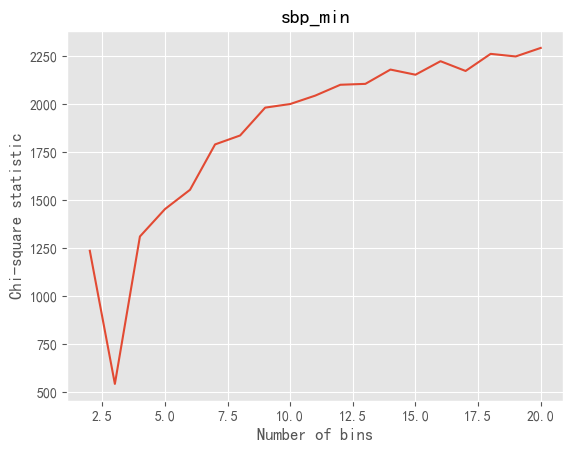

Number of bins: 2, Chi-square statistic: 75.41062799898734, p-value: 2.958660839705066e-16
Number of bins: 3, Chi-square statistic: 537.0064635790685, p-value: 8.925488591615884e-113
Number of bins: 4, Chi-square statistic: 305.8564591196756, p-value: 1.493358879142416e-60
Number of bins: 5, Chi-square statistic: 399.0815433092017, p-value: 5.922228807528976e-78
Number of bins: 6, Chi-square statistic: 608.1910503673627, p-value: 6.453209971522824e-120
Number of bins: 7, Chi-square statistic: 540.6086780936481, p-value: 2.955412954826867e-103
Number of bins: 8, Chi-square statistic: 576.1827420164184, p-value: 1.6188920237446918e-108
Number of bins: 9, Chi-square statistic: 631.7745015101198, p-value: 5.259557951173996e-118
Number of bins: 10, Chi-square statistic: 599.8895201140286, p-value: 3.04754214759146e-109
Number of bins: 11, Chi-square statistic: 658.6077900590766, p-value: 2.0412213070070434e-119
Number of bins: 12, Chi-square statistic: 694.5760734080944, p-value: 7.24461640

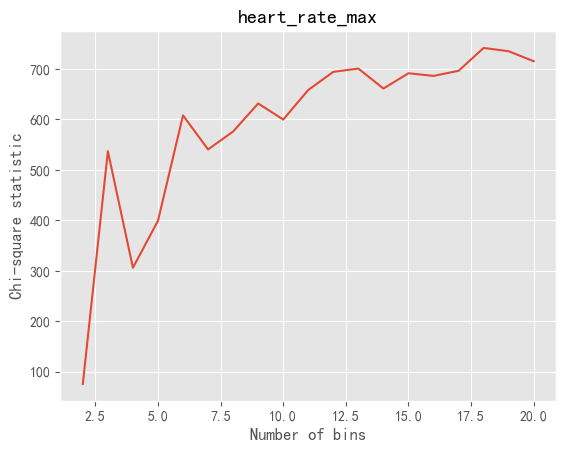

Number of bins: 2, Chi-square statistic: 399.5106810576794, p-value: 2.82582426613938e-86
Number of bins: 3, Chi-square statistic: 221.00973621614014, p-value: 6.337794403413082e-45
Number of bins: 4, Chi-square statistic: 426.7365191635788, p-value: 2.6841156405209065e-86
Number of bins: 5, Chi-square statistic: 404.96792545091455, p-value: 3.3566643700296106e-79
Number of bins: 6, Chi-square statistic: 493.4400824359582, p-value: 1.3790823100757966e-95
Number of bins: 7, Chi-square statistic: 492.7049891612847, p-value: 3.5619090560899063e-93
Number of bins: 8, Chi-square statistic: 521.5593470785484, p-value: 4.58291983576948e-97
Number of bins: 9, Chi-square statistic: 568.9141979900683, p-value: 7.446369239053612e-105
Number of bins: 10, Chi-square statistic: 538.0166076607783, p-value: 2.141400016597534e-96
Number of bins: 11, Chi-square statistic: 577.880247672506, p-value: 1.1150392163508862e-102
Number of bins: 12, Chi-square statistic: 587.59117469078, p-value: 9.315040248925

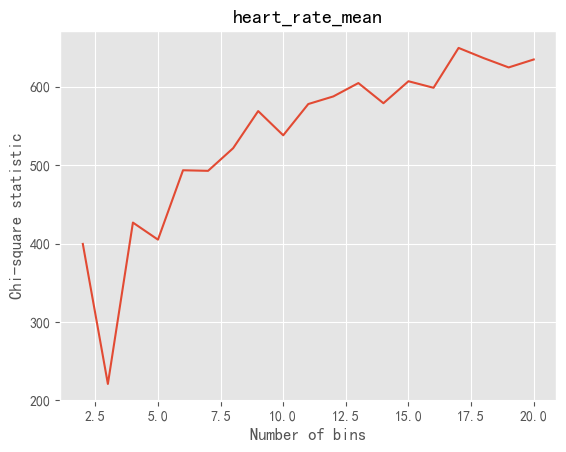

Number of bins: 2, Chi-square statistic: 140.58100318533965, p-value: 2.8325878318282284e-30
Number of bins: 3, Chi-square statistic: 156.07607857190663, p-value: 4.01071677843209e-31
Number of bins: 4, Chi-square statistic: 187.79712432159397, p-value: 1.1894610363224547e-35
Number of bins: 5, Chi-square statistic: 243.64342736335317, p-value: 2.890607066584381e-45
Number of bins: 6, Chi-square statistic: 247.14001687389316, p-value: 4.817198108533603e-44
Number of bins: 7, Chi-square statistic: 307.0002115546715, p-value: 1.7465604112014844e-54
Number of bins: 8, Chi-square statistic: 269.0169696837921, p-value: 6.081956381336264e-45
Number of bins: 9, Chi-square statistic: 279.7488127133141, p-value: 1.9524099688842187e-45
Number of bins: 10, Chi-square statistic: 289.0514079085093, p-value: 1.092557967669966e-45
Number of bins: 11, Chi-square statistic: 295.05186261028666, p-value: 2.494699334408384e-45
Number of bins: 12, Chi-square statistic: 293.5213868378736, p-value: 1.5066614

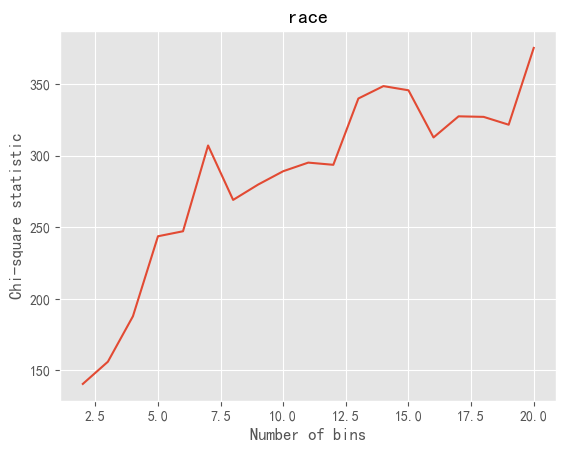

Number of bins: 2, Chi-square statistic: 1269.1591116277489, p-value: 7.238364786407984e-275
Number of bins: 3, Chi-square statistic: 1490.475522106208, p-value: 0.0
Number of bins: 4, Chi-square statistic: 1750.7279776253495, p-value: 0.0
Number of bins: 5, Chi-square statistic: 1864.700280395045, p-value: 0.0
Number of bins: 6, Chi-square statistic: 1853.9497036184912, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1888.6471257206988, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1919.409341845711, p-value: 0.0
Number of bins: 9, Chi-square statistic: 1917.1267574392405, p-value: 0.0
Number of bins: 10, Chi-square statistic: 1969.8365641093462, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1966.9792972999874, p-value: 0.0
Number of bins: 12, Chi-square statistic: 1975.5761948736579, p-value: 0.0
Number of bins: 13, Chi-square statistic: 1981.8507827812869, p-value: 0.0
Number of bins: 14, Chi-square statistic: 1984.8843408445755, p-value: 0.0
Number of bins: 1

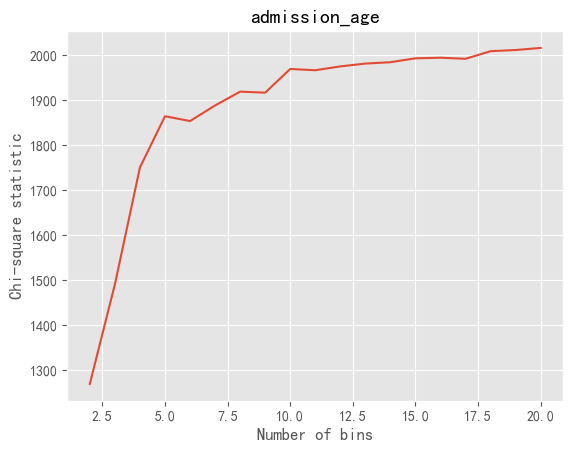

In [54]:
for col in cols:
    get_best_bin(train, col)

In [6]:
def get_best_bin_qcut(df, feature_name):
    data = pd.DataFrame(df['aki'])
    max_bins = 20
    number_of_bins = []
    chi_square_stats = []
    for num_bins in range(2, max_bins+1):
        data["bin"] = pd.qcut(df[feature_name], bins=num_bins)

        observed = pd.crosstab(data["bin"], data["aki"])
        chi2, p, _, _ = stats.chi2_contingency(observed)
        print(f"Number of bins: {num_bins}, Chi-square statistic: {chi2}, p-value: {p}")
        number_of_bins.append(num_bins)
        chi_square_stats.append(chi2)

    plt.plot(number_of_bins, chi_square_stats)
    plt.xlabel('Number of bins')
    plt.ylabel('Chi-square statistic')
    plt.title(f'{feature_name}')
    plt.show()

Number of bins: 2, Chi-square statistic: 21.91638848043811, p-value: 6.789700989324417e-05
Number of bins: 3, Chi-square statistic: 195.66368338284096, p-value: 1.5884708148150688e-39
Number of bins: 4, Chi-square statistic: 749.6619196703649, p-value: 1.4448596656883736e-155
Number of bins: 5, Chi-square statistic: 1027.9730002414776, p-value: 1.812648686296003e-212
Number of bins: 6, Chi-square statistic: 775.6647644210299, p-value: 1.3424904421584216e-155
Number of bins: 7, Chi-square statistic: 866.6723497560306, p-value: 2.0028249488956557e-172
Number of bins: 8, Chi-square statistic: 1173.2683339301889, p-value: 3.0216897354286722e-235
Number of bins: 9, Chi-square statistic: 1351.8800837667434, p-value: 9.50427137044638e-271
Number of bins: 10, Chi-square statistic: 1421.7158441503475, p-value: 5.013857742500788e-283
Number of bins: 11, Chi-square statistic: 1150.1256253750641, p-value: 9.113472430734799e-223
Number of bins: 12, Chi-square statistic: 1154.1428846868776, p-value:

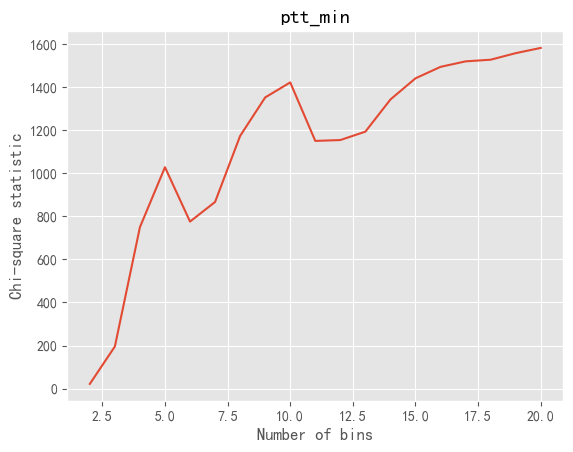

Number of bins: 2, Chi-square statistic: 11.019989902708758, p-value: 0.011618272240406175
Number of bins: 3, Chi-square statistic: 43.09108729812985, p-value: 1.1190107945625624e-07
Number of bins: 4, Chi-square statistic: 457.46230182138504, p-value: 7.277543897236962e-93
Number of bins: 5, Chi-square statistic: 459.41513833676015, p-value: 9.451060214655137e-91
Number of bins: 6, Chi-square statistic: 421.2758443249999, p-value: 2.3201356464642034e-80
Number of bins: 7, Chi-square statistic: 361.8472450332516, p-value: 7.940300269977177e-66
Number of bins: 8, Chi-square statistic: 755.3634546148169, p-value: 2.595993098902938e-146
Number of bins: 9, Chi-square statistic: 802.3600056306828, p-value: 6.566862340905287e-154
Number of bins: 10, Chi-square statistic: 836.2237345475685, p-value: 9.17264648840176e-159
Number of bins: 11, Chi-square statistic: 956.1764823815673, p-value: 9.005314794897647e-182
Number of bins: 12, Chi-square statistic: 1143.32196038817, p-value: 5.7967880940

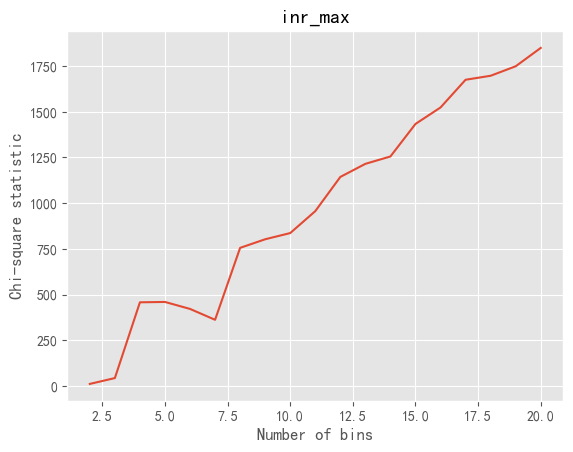

Number of bins: 2, Chi-square statistic: 10.195688053259625, p-value: 0.01697390124162791
Number of bins: 3, Chi-square statistic: 100.34056232684506, p-value: 2.1305669072365169e-19
Number of bins: 4, Chi-square statistic: 241.96553010219242, p-value: 4.947455111743777e-47
Number of bins: 5, Chi-square statistic: 495.25072143316277, p-value: 2.2713756659531513e-98
Number of bins: 6, Chi-square statistic: 190.7042990145467, p-value: 1.632737749233063e-32
Number of bins: 7, Chi-square statistic: 196.16168122897514, p-value: 5.857587886454078e-32
Number of bins: 8, Chi-square statistic: 708.9103482067586, p-value: 1.7391375456278158e-136
Number of bins: 9, Chi-square statistic: 960.8750592989695, p-value: 1.8010259406395782e-187
Number of bins: 10, Chi-square statistic: 788.8438585910709, p-value: 8.611155086445098e-149
Number of bins: 11, Chi-square statistic: 906.4407044821445, p-value: 2.6941440841586702e-171
Number of bins: 12, Chi-square statistic: 993.4201889583471, p-value: 2.3426

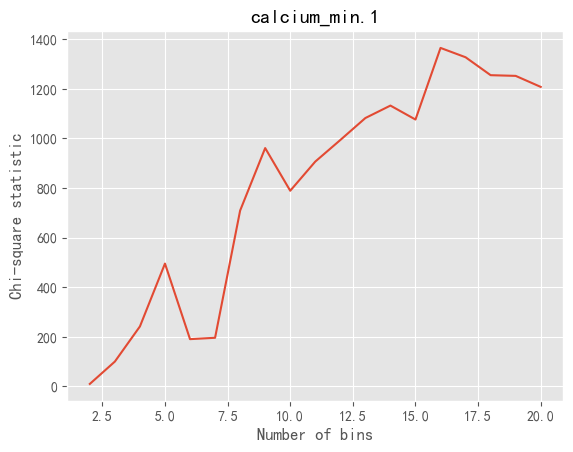

Number of bins: 2, Chi-square statistic: 120.79279458968425, p-value: 5.208231187398556e-26
Number of bins: 3, Chi-square statistic: 258.16783757369234, p-value: 7.362227949414909e-53
Number of bins: 4, Chi-square statistic: 207.56053888554996, p-value: 8.596276456733367e-40
Number of bins: 5, Chi-square statistic: 323.7799925173739, p-value: 4.7046189770908065e-62
Number of bins: 6, Chi-square statistic: 342.0039972241009, p-value: 9.86001334620637e-64
Number of bins: 7, Chi-square statistic: 432.2892478704075, p-value: 1.6531693823264301e-80
Number of bins: 8, Chi-square statistic: 310.6082708882252, p-value: 2.194800064920277e-53
Number of bins: 9, Chi-square statistic: 465.10553664548615, p-value: 2.851969174371192e-83
Number of bins: 10, Chi-square statistic: 561.1711773634565, p-value: 3.393339689459822e-101
Number of bins: 11, Chi-square statistic: 551.3512017353306, p-value: 3.3367451199425946e-97
Number of bins: 12, Chi-square statistic: 444.15724652068855, p-value: 3.09960183

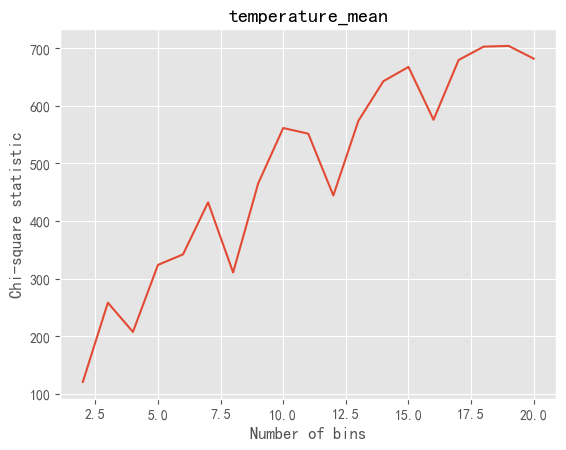

Number of bins: 2, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 3, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 4, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 5, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 6, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 7, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 8, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 9, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 10, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 11, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 12, Chi-square statistic: 1.0722350598623647, p-value: 0.7837805214439258
Number of bins: 13

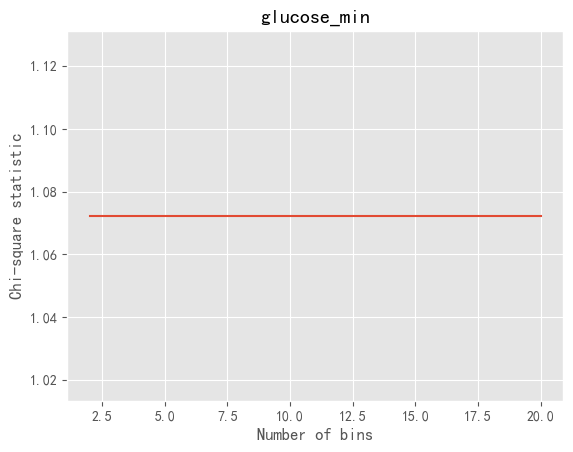

Number of bins: 2, Chi-square statistic: 0.43016580770364227, p-value: 0.9339428115258928
Number of bins: 3, Chi-square statistic: 4.931959491969136, p-value: 0.5525690533384189
Number of bins: 4, Chi-square statistic: 6.3135583896861345, p-value: 0.708171987558335
Number of bins: 5, Chi-square statistic: 12.112033693226897, p-value: 0.20706683308111923
Number of bins: 6, Chi-square statistic: 17.621809005040312, p-value: 0.12766549795313514
Number of bins: 7, Chi-square statistic: 20.386787501531963, p-value: 0.06011396458347986
Number of bins: 8, Chi-square statistic: 17.58865329366167, p-value: 0.1287631862271209
Number of bins: 9, Chi-square statistic: 22.321677947208332, p-value: 0.03406879071192475
Number of bins: 10, Chi-square statistic: 33.235259683001296, p-value: 0.0043544381662368944
Number of bins: 11, Chi-square statistic: 33.235259683001296, p-value: 0.0043544381662368944
Number of bins: 12, Chi-square statistic: 30.05554133463135, p-value: 0.011722788030043164
Number of

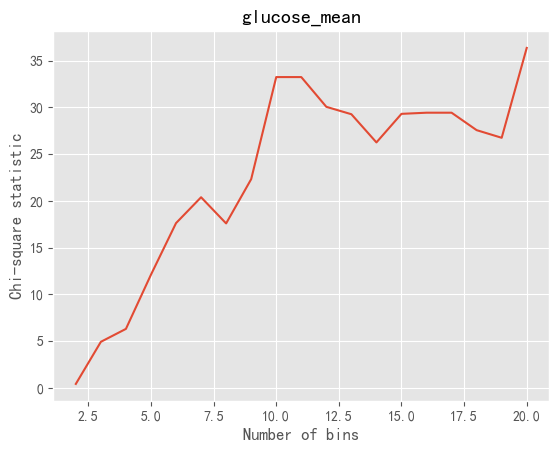

Number of bins: 2, Chi-square statistic: 5.455143461374299, p-value: 0.14134628747330286
Number of bins: 3, Chi-square statistic: 5.455143461374299, p-value: 0.14134628747330286
Number of bins: 4, Chi-square statistic: 5.455143461374299, p-value: 0.14134628747330286
Number of bins: 5, Chi-square statistic: 9.613980883552141, p-value: 0.14187782815031547
Number of bins: 6, Chi-square statistic: 9.26239681434436, p-value: 0.15934993355045704
Number of bins: 7, Chi-square statistic: 9.26239681434436, p-value: 0.15934993355045704
Number of bins: 8, Chi-square statistic: 7.33120411567352, p-value: 0.2913004378437687
Number of bins: 9, Chi-square statistic: 5.487057799410124, p-value: 0.48302232407117474
Number of bins: 10, Chi-square statistic: 10.820470342527322, p-value: 0.2882158597027516
Number of bins: 11, Chi-square statistic: 11.395065812754936, p-value: 0.24959782306938624
Number of bins: 12, Chi-square statistic: 11.043500596745657, p-value: 0.2727389777726947
Number of bins: 13, C

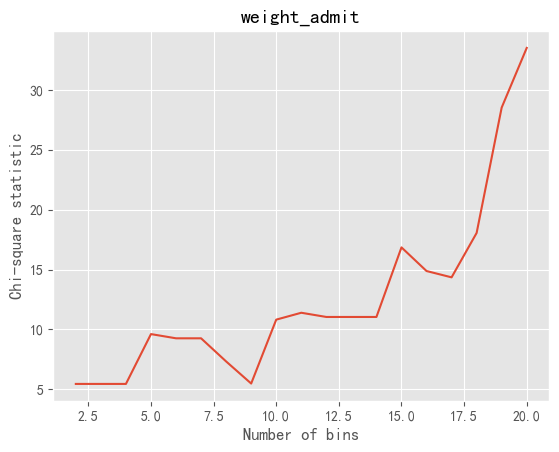

Number of bins: 2, Chi-square statistic: 61.14056523883753, p-value: 3.3537938023836243e-13
Number of bins: 3, Chi-square statistic: 335.94933165359174, p-value: 1.6001398418307282e-69
Number of bins: 4, Chi-square statistic: 772.3369592597712, p-value: 1.9106390193882862e-160
Number of bins: 5, Chi-square statistic: 1467.891048048501, p-value: 3.1886838438159124e-307
Number of bins: 6, Chi-square statistic: 1821.1689338246065, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1649.9677180940548, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1399.0882725406195, p-value: 2.23784593924674e-286
Number of bins: 9, Chi-square statistic: 1494.5655042500446, p-value: 7.018616615194775e-307
Number of bins: 10, Chi-square statistic: 1728.0589671481316, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1895.5675185656596, p-value: 0.0
Number of bins: 12, Chi-square statistic: 2036.01725108427, p-value: 0.0
Number of bins: 13, Chi-square statistic: 2017.2596147926606, p-value: 0.

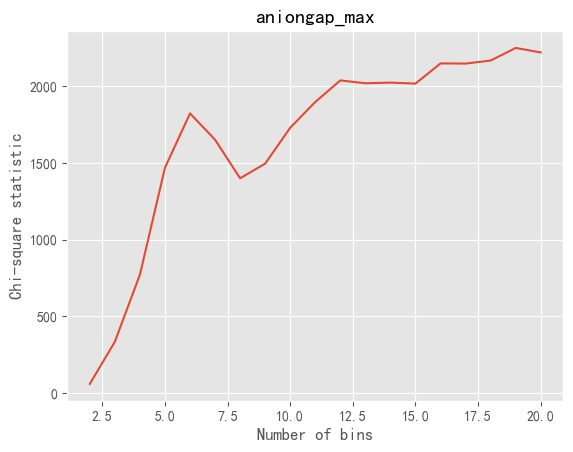

Number of bins: 2, Chi-square statistic: 822.9568160760975, p-value: 4.5431106822285273e-178
Number of bins: 3, Chi-square statistic: 446.9279214456527, p-value: 2.249607864076919e-93
Number of bins: 4, Chi-square statistic: 1049.3409263330832, p-value: 3.938883886825582e-220
Number of bins: 5, Chi-square statistic: 1213.0816348306964, p-value: 2.638625845592472e-252
Number of bins: 6, Chi-square statistic: 1107.8939514773142, p-value: 9.759158675737898e-227
Number of bins: 7, Chi-square statistic: 1462.9915961201718, p-value: 4.2496653639022594e-300
Number of bins: 8, Chi-square statistic: 1513.9865112860618, p-value: 3.503653052670081e-308
Number of bins: 9, Chi-square statistic: 1596.9082226450596, p-value: 0.0
Number of bins: 10, Chi-square statistic: 1593.8917173970135, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1825.5947204715405, p-value: 0.0
Number of bins: 12, Chi-square statistic: 1949.9423519076322, p-value: 0.0
Number of bins: 13, Chi-square statistic: 1892.9989

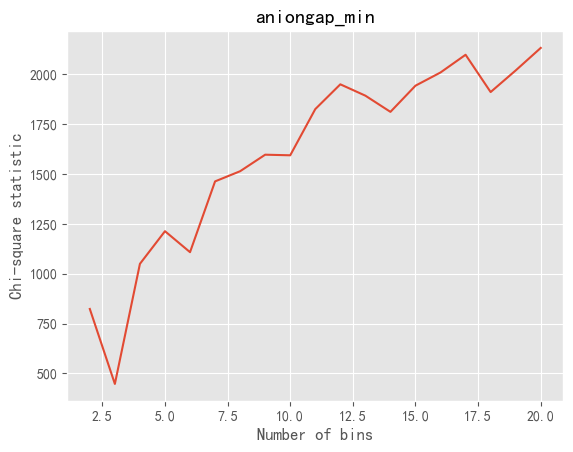

Number of bins: 2, Chi-square statistic: 273.01843310413295, p-value: 6.861493166389834e-59
Number of bins: 3, Chi-square statistic: 78.90267045404367, p-value: 6.020102201518355e-15
Number of bins: 4, Chi-square statistic: 321.3126555201559, p-value: 7.804529957068511e-64
Number of bins: 5, Chi-square statistic: 563.3558606625105, p-value: 7.017173036826018e-113
Number of bins: 6, Chi-square statistic: 390.07419829083324, p-value: 8.408820989964593e-74
Number of bins: 7, Chi-square statistic: 657.4017379500724, p-value: 6.11758272964595e-128
Number of bins: 8, Chi-square statistic: 663.3454738203911, p-value: 7.266885293536841e-127
Number of bins: 9, Chi-square statistic: 601.9049280650437, p-value: 9.471994956440915e-112
Number of bins: 10, Chi-square statistic: 741.6384160713924, p-value: 7.104087094227821e-139
Number of bins: 11, Chi-square statistic: 684.4257898227103, p-value: 8.642782446672419e-125
Number of bins: 12, Chi-square statistic: 805.0812996637835, p-value: 7.164886217

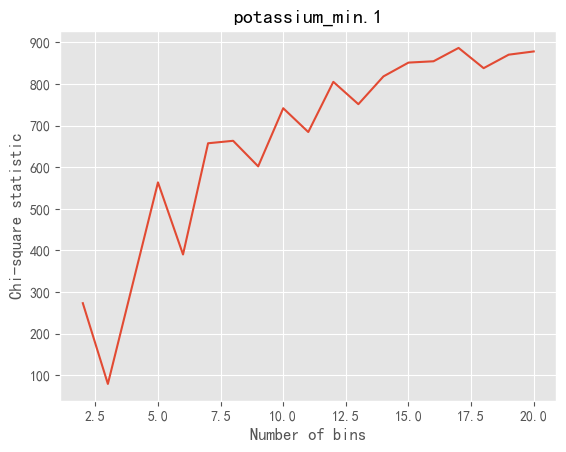

Number of bins: 2, Chi-square statistic: 44.042755250676166, p-value: 1.4779490360901312e-09
Number of bins: 3, Chi-square statistic: 898.4603350146598, p-value: 8.084598871522944e-191
Number of bins: 4, Chi-square statistic: 431.613626952431, p-value: 2.437492829616492e-87
Number of bins: 5, Chi-square statistic: 647.6665537687921, p-value: 6.920819533627246e-131
Number of bins: 6, Chi-square statistic: 983.5757060420851, p-value: 4.4610642459768316e-200
Number of bins: 7, Chi-square statistic: 896.9578510981177, p-value: 6.987024419211524e-179
Number of bins: 8, Chi-square statistic: 1093.5344509350552, p-value: 3.194448394865937e-218
Number of bins: 9, Chi-square statistic: 1137.1350705751822, p-value: 6.083773356601345e-225
Number of bins: 10, Chi-square statistic: 1180.6112852483077, p-value: 1.1171812746679023e-231
Number of bins: 11, Chi-square statistic: 1229.0808957477677, p-value: 1.6510653148973473e-239
Number of bins: 12, Chi-square statistic: 1211.0891652863088, p-value: 2

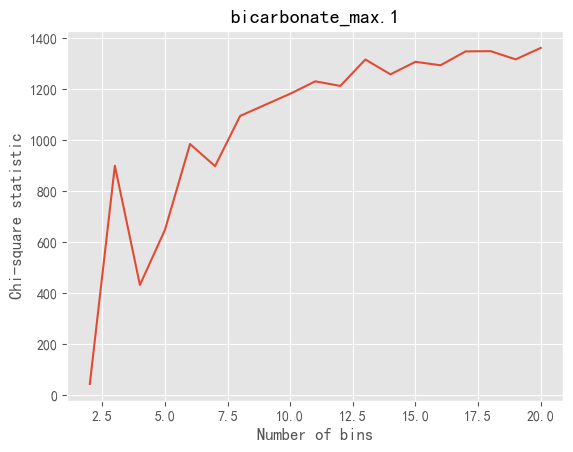

Number of bins: 2, Chi-square statistic: 82.92985234189004, p-value: 7.21858670300729e-18
Number of bins: 3, Chi-square statistic: 165.39877803183214, p-value: 4.2519511040519416e-33
Number of bins: 4, Chi-square statistic: 253.46956027717238, p-value: 1.8464582642923837e-49
Number of bins: 5, Chi-square statistic: 956.475942838788, p-value: 4.2411323379627694e-197
Number of bins: 6, Chi-square statistic: 446.56381963313845, p-value: 1.0916535743617485e-85
Number of bins: 7, Chi-square statistic: 615.6860045782341, p-value: 4.1494789375329367e-119
Number of bins: 8, Chi-square statistic: 779.2571612521772, p-value: 2.2594117315314272e-151
Number of bins: 9, Chi-square statistic: 873.6721321700621, p-value: 5.468956575732852e-169
Number of bins: 10, Chi-square statistic: 1033.0270703833473, p-value: 2.3551991469654906e-200
Number of bins: 11, Chi-square statistic: 1008.2814523295494, p-value: 9.161928931273073e-193
Number of bins: 12, Chi-square statistic: 910.9557462705202, p-value: 4.

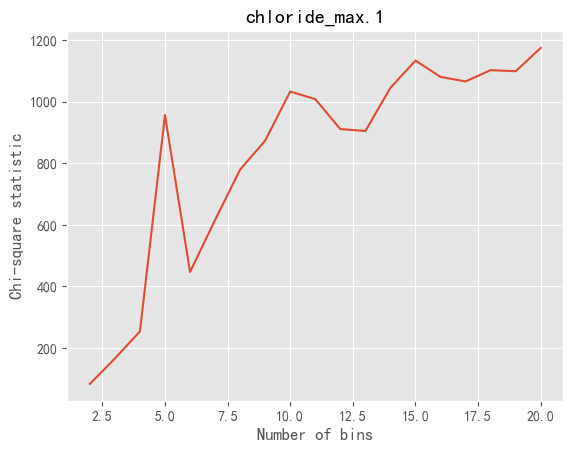

Number of bins: 2, Chi-square statistic: 1708.334296326125, p-value: 0.0
Number of bins: 3, Chi-square statistic: 1717.5128130643368, p-value: 0.0
Number of bins: 4, Chi-square statistic: 1737.221326207386, p-value: 0.0
Number of bins: 5, Chi-square statistic: 2053.625596284179, p-value: 0.0
Number of bins: 6, Chi-square statistic: 2053.4274287866883, p-value: 0.0
Number of bins: 7, Chi-square statistic: 2054.0674497248315, p-value: 0.0
Number of bins: 8, Chi-square statistic: 2060.903895584105, p-value: 0.0
Number of bins: 9, Chi-square statistic: 2136.8782997828257, p-value: 0.0
Number of bins: 10, Chi-square statistic: 2161.010754637452, p-value: 0.0
Number of bins: 11, Chi-square statistic: 2093.8455855159546, p-value: 0.0
Number of bins: 12, Chi-square statistic: 2121.0712940809917, p-value: 0.0
Number of bins: 13, Chi-square statistic: 2191.179444619366, p-value: 0.0
Number of bins: 14, Chi-square statistic: 2197.94065297197, p-value: 0.0
Number of bins: 15, Chi-square statistic:

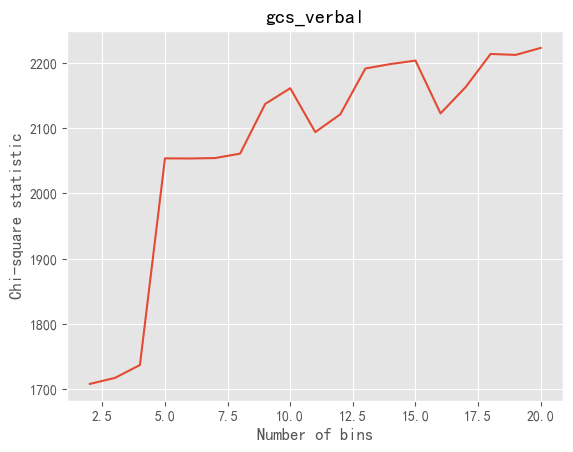

Number of bins: 2, Chi-square statistic: 987.6094229177278, p-value: 8.770218768568508e-214
Number of bins: 3, Chi-square statistic: 599.3712686183189, p-value: 3.1870059976569136e-126
Number of bins: 4, Chi-square statistic: 1024.8174917739802, p-value: 7.668202461599359e-215
Number of bins: 5, Chi-square statistic: 1064.3243546622894, p-value: 2.754442184501807e-220
Number of bins: 6, Chi-square statistic: 1212.7143430710466, p-value: 3.0387973649749873e-249
Number of bins: 7, Chi-square statistic: 1175.7113343289695, p-value: 1.786953503152611e-238
Number of bins: 8, Chi-square statistic: 1235.5909116850564, p-value: 1.4462712091911074e-248
Number of bins: 9, Chi-square statistic: 1312.5950292457262, p-value: 2.3328825838785717e-262
Number of bins: 10, Chi-square statistic: 1310.9773088520446, p-value: 2.0284961682511057e-259
Number of bins: 11, Chi-square statistic: 1310.9784912259756, p-value: 6.691273546754136e-257
Number of bins: 12, Chi-square statistic: 1369.375532714241, p-va

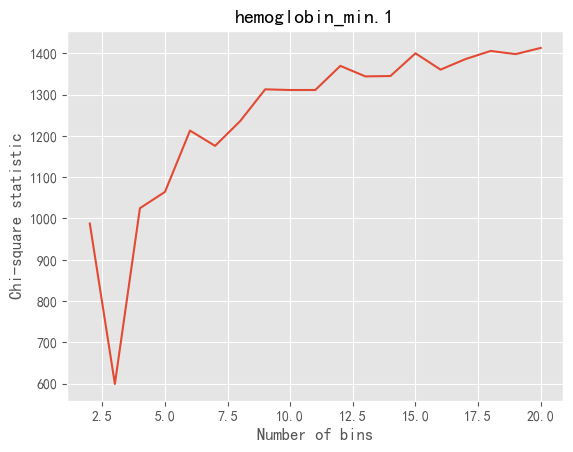

Number of bins: 2, Chi-square statistic: 564.1296743801815, p-value: 6.014437490506709e-122
Number of bins: 3, Chi-square statistic: 552.0974264970757, p-value: 4.9848837744331365e-116
Number of bins: 4, Chi-square statistic: 676.195111829124, p-value: 9.049107540521823e-140
Number of bins: 5, Chi-square statistic: 758.7504376049351, p-value: 1.151717344771755e-154
Number of bins: 6, Chi-square statistic: 891.5999220888399, p-value: 2.214004730313578e-180
Number of bins: 7, Chi-square statistic: 967.541404351476, p-value: 6.023877158996554e-194
Number of bins: 8, Chi-square statistic: 937.910614670602, p-value: 4.62997566362051e-185
Number of bins: 9, Chi-square statistic: 958.1911664213984, p-value: 6.683222869267298e-187
Number of bins: 10, Chi-square statistic: 1034.7229401942093, p-value: 1.0295828393471253e-200
Number of bins: 11, Chi-square statistic: 1005.7059303684371, p-value: 3.2043157289315963e-192
Number of bins: 12, Chi-square statistic: 1071.3081167916412, p-value: 9.1974

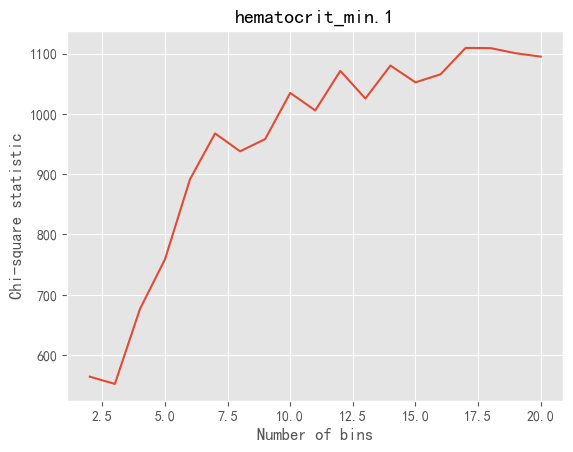

Number of bins: 2, Chi-square statistic: 174.91348842803424, p-value: 1.1061964367030513e-37
Number of bins: 3, Chi-square statistic: 1024.6022474452952, p-value: 4.267415959821839e-218
Number of bins: 4, Chi-square statistic: 1718.5171485288438, p-value: 0.0
Number of bins: 5, Chi-square statistic: 2431.3077874809965, p-value: 0.0
Number of bins: 6, Chi-square statistic: 3032.641597190892, p-value: 0.0
Number of bins: 7, Chi-square statistic: 3576.912467323176, p-value: 0.0
Number of bins: 8, Chi-square statistic: 3952.124081854041, p-value: 0.0
Number of bins: 9, Chi-square statistic: 4184.8925979771575, p-value: 0.0
Number of bins: 10, Chi-square statistic: 4451.029916252322, p-value: 0.0
Number of bins: 11, Chi-square statistic: 4528.000395435452, p-value: 0.0
Number of bins: 12, Chi-square statistic: 4788.262232439707, p-value: 0.0
Number of bins: 13, Chi-square statistic: 4930.221790496677, p-value: 0.0
Number of bins: 14, Chi-square statistic: 5062.377138967626, p-value: 0.0
Num

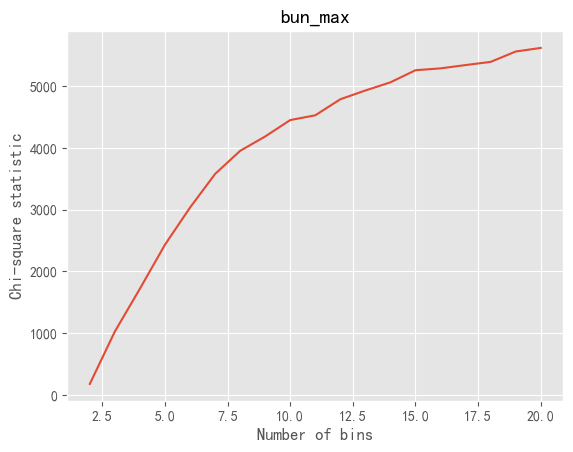

Number of bins: 2, Chi-square statistic: 1017.4132253689418, p-value: 3.0035868078644975e-220
Number of bins: 3, Chi-square statistic: 1370.8278411632416, p-value: 5.019489646776971e-293
Number of bins: 4, Chi-square statistic: 1382.4944586794106, p-value: 4.681841171647687e-292
Number of bins: 5, Chi-square statistic: 1465.025861486606, p-value: 1.3229455634002517e-306
Number of bins: 6, Chi-square statistic: 1515.8065725312288, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1459.910582566959, p-value: 1.9501761206955376e-299
Number of bins: 8, Chi-square statistic: 1499.2411083097563, p-value: 5.082985023510168e-305
Number of bins: 9, Chi-square statistic: 1536.657405894872, p-value: 2.91877267969873e-310
Number of bins: 10, Chi-square statistic: 1507.3516537849255, p-value: 2.6404277476065138e-301
Number of bins: 11, Chi-square statistic: 1525.33046404774, p-value: 1.581250166280798e-302
Number of bins: 12, Chi-square statistic: 1554.329677399257, p-value: 3.7854994224116115e

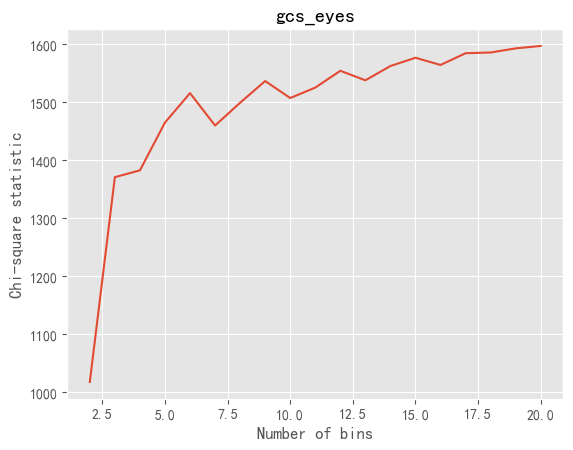

Number of bins: 2, Chi-square statistic: 167.6676311023541, p-value: 4.0566600173543265e-36
Number of bins: 3, Chi-square statistic: 678.3022056284163, p-value: 2.957093392882587e-143
Number of bins: 4, Chi-square statistic: 516.6067007229777, p-value: 1.595852849035326e-105
Number of bins: 5, Chi-square statistic: 650.0690058965835, p-value: 2.1207360198547916e-131
Number of bins: 6, Chi-square statistic: 769.1443306117685, p-value: 3.3115964621530355e-154
Number of bins: 7, Chi-square statistic: 824.7874588731473, p-value: 1.67935045872126e-163
Number of bins: 8, Chi-square statistic: 833.7348685759575, p-value: 6.344605589826617e-163
Number of bins: 9, Chi-square statistic: 924.6071471636748, p-value: 8.863151976877787e-180
Number of bins: 10, Chi-square statistic: 906.0547370566535, p-value: 1.7110359506432364e-173
Number of bins: 11, Chi-square statistic: 946.4195609236543, p-value: 1.0255599696072843e-179
Number of bins: 12, Chi-square statistic: 928.9918671949924, p-value: 8.123

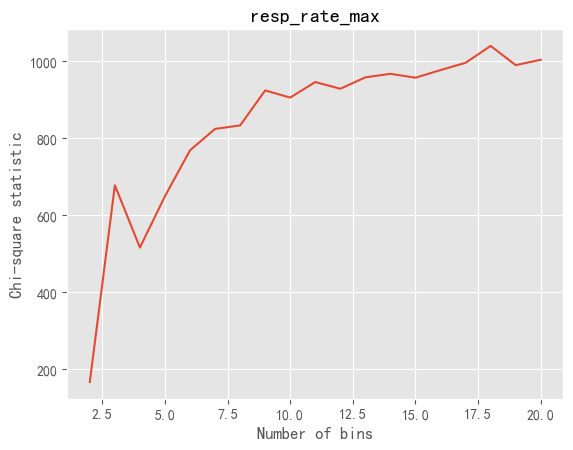

Number of bins: 2, Chi-square statistic: 19.55857085085064, p-value: 0.00020952098582545674
Number of bins: 3, Chi-square statistic: 175.88655264692775, p-value: 2.534962373842467e-35
Number of bins: 4, Chi-square statistic: 131.381351547587, p-value: 6.164801587248721e-24
Number of bins: 5, Chi-square statistic: 150.55518662656348, p-value: 4.37447751866704e-26
Number of bins: 6, Chi-square statistic: 268.47690360051786, p-value: 1.9117604810465426e-48
Number of bins: 7, Chi-square statistic: 355.04191883394316, p-value: 2.051210766676621e-64
Number of bins: 8, Chi-square statistic: 313.7979188068199, p-value: 4.905013192162846e-54
Number of bins: 9, Chi-square statistic: 309.3499321737947, p-value: 2.186710517084977e-51
Number of bins: 10, Chi-square statistic: 369.7683874941713, p-value: 1.1669180826108764e-63
Number of bins: 11, Chi-square statistic: 401.2033411418404, p-value: 2.842102051383201e-68
Number of bins: 12, Chi-square statistic: 386.61127645774894, p-value: 1.4057454235

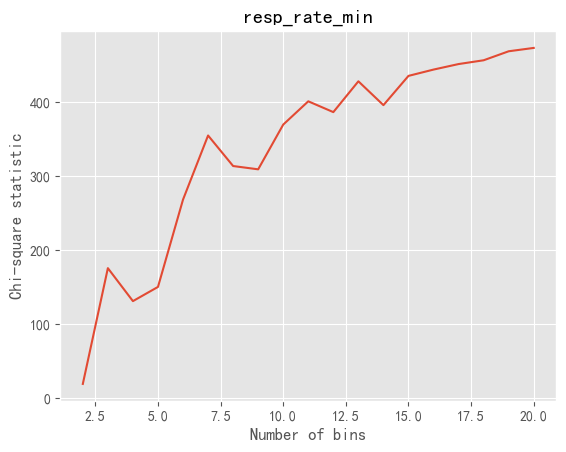

Number of bins: 2, Chi-square statistic: 44.98384543297063, p-value: 9.32613690337433e-10
Number of bins: 3, Chi-square statistic: 62.81672395259399, p-value: 1.202871326386973e-11
Number of bins: 4, Chi-square statistic: 81.4832182878755, p-value: 8.196102897122855e-14
Number of bins: 5, Chi-square statistic: 112.09999141257393, p-value: 2.2975967394670653e-18
Number of bins: 6, Chi-square statistic: 96.35076028192006, p-value: 6.387556868917164e-14
Number of bins: 7, Chi-square statistic: 109.32058419126322, p-value: 4.211117410177512e-15
Number of bins: 8, Chi-square statistic: 121.02938020468251, p-value: 4.621645211310911e-16
Number of bins: 9, Chi-square statistic: 133.09035300134383, p-value: 4.264916304885873e-17
Number of bins: 10, Chi-square statistic: 216.74365392766782, p-value: 1.5512553946146666e-31
Number of bins: 11, Chi-square statistic: 217.32746887139774, p-value: 2.703678277089085e-30
Number of bins: 12, Chi-square statistic: 220.56717781040675, p-value: 1.297908967

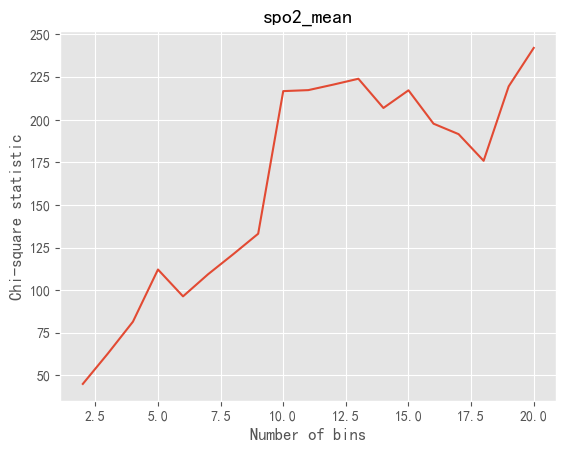

Number of bins: 2, Chi-square statistic: 54.04706665811429, p-value: 1.0964231888400253e-11
Number of bins: 3, Chi-square statistic: 83.24131495561134, p-value: 7.63532333797445e-16
Number of bins: 4, Chi-square statistic: 200.79145304125842, p-value: 2.2610027681923053e-38
Number of bins: 5, Chi-square statistic: 244.9925143385542, p-value: 1.5133122498036295e-45
Number of bins: 6, Chi-square statistic: 356.2109604513731, p-value: 1.0546143715264083e-66
Number of bins: 7, Chi-square statistic: 456.59073158011955, p-value: 1.350390731071624e-85
Number of bins: 8, Chi-square statistic: 625.4760257590508, p-value: 6.963682656842903e-119
Number of bins: 9, Chi-square statistic: 838.4145314933718, p-value: 1.576443296690088e-161
Number of bins: 10, Chi-square statistic: 893.4666661572373, p-value: 7.77939514556169e-171
Number of bins: 11, Chi-square statistic: 918.2175441299235, p-value: 8.941749699583364e-174
Number of bins: 12, Chi-square statistic: 959.1932358240896, p-value: 3.68539803

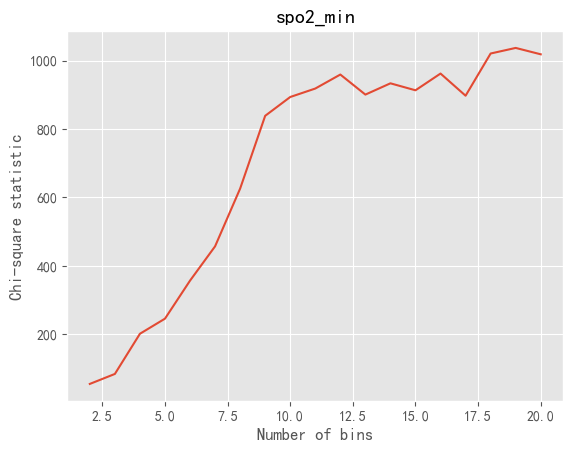

Number of bins: 2, Chi-square statistic: 898.2990136178222, p-value: 2.0700499481477565e-194
Number of bins: 3, Chi-square statistic: 962.4101269054634, p-value: 1.2042916731619552e-204
Number of bins: 4, Chi-square statistic: 1195.0338095252202, p-value: 1.431640423129977e-251
Number of bins: 5, Chi-square statistic: 1491.054691562092, p-value: 0.0
Number of bins: 6, Chi-square statistic: 1537.0999169848933, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1727.2818641038943, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1758.2106303582977, p-value: 0.0
Number of bins: 9, Chi-square statistic: 1814.2114190319362, p-value: 0.0
Number of bins: 10, Chi-square statistic: 1837.033182943798, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1934.1003918740303, p-value: 0.0
Number of bins: 12, Chi-square statistic: 1921.578428912924, p-value: 0.0
Number of bins: 13, Chi-square statistic: 1938.7780619977502, p-value: 0.0
Number of bins: 14, Chi-square statistic: 1989.8907461

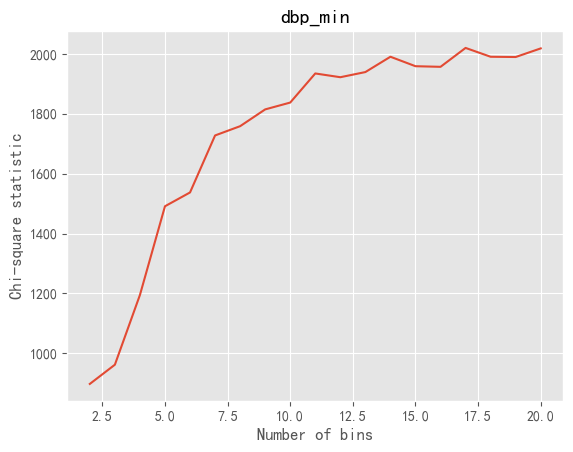

Number of bins: 2, Chi-square statistic: 262.96718340964003, p-value: 1.0254977168479206e-56
Number of bins: 3, Chi-square statistic: 142.83655911405708, p-value: 2.524553013182164e-28
Number of bins: 4, Chi-square statistic: 347.6362254518665, p-value: 1.9734383110970874e-69
Number of bins: 5, Chi-square statistic: 567.735905879086, p-value: 8.162159362271123e-114
Number of bins: 6, Chi-square statistic: 446.9860548072062, p-value: 8.893102832753959e-86
Number of bins: 7, Chi-square statistic: 611.9857332981171, p-value: 2.5154922536042015e-118
Number of bins: 8, Chi-square statistic: 643.1970998114235, p-value: 1.2872171319976142e-122
Number of bins: 9, Chi-square statistic: 650.087228509028, p-value: 7.593776427564048e-122
Number of bins: 10, Chi-square statistic: 709.9324616366091, p-value: 3.16120165470804e-132
Number of bins: 11, Chi-square statistic: 738.7164874924412, p-value: 4.077061196477166e-136
Number of bins: 12, Chi-square statistic: 758.8826437164347, p-value: 3.0928929

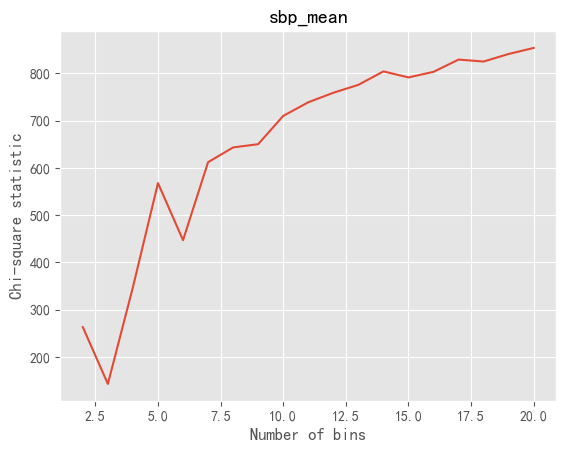

Number of bins: 2, Chi-square statistic: 1236.3949165357863, p-value: 9.303034854310945e-268
Number of bins: 3, Chi-square statistic: 542.2729063440333, p-value: 6.53858619975951e-114
Number of bins: 4, Chi-square statistic: 1311.0837875501184, p-value: 1.2489688051000373e-276
Number of bins: 5, Chi-square statistic: 1453.9221730381528, p-value: 3.282308223557433e-304
Number of bins: 6, Chi-square statistic: 1554.6027928077772, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1791.152431523598, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1837.7756953336366, p-value: 0.0
Number of bins: 9, Chi-square statistic: 1982.9508973301722, p-value: 0.0
Number of bins: 10, Chi-square statistic: 2001.7461655656195, p-value: 0.0
Number of bins: 11, Chi-square statistic: 2045.659218046004, p-value: 0.0
Number of bins: 12, Chi-square statistic: 2102.154056534084, p-value: 0.0
Number of bins: 13, Chi-square statistic: 2106.893198732739, p-value: 0.0
Number of bins: 14, Chi-square statis

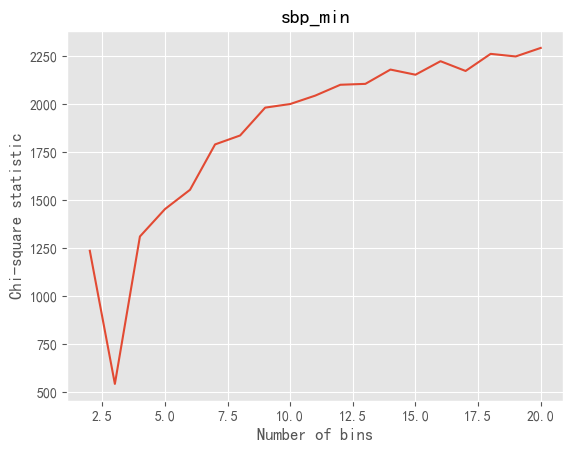

Number of bins: 2, Chi-square statistic: 75.41062799898734, p-value: 2.958660839705066e-16
Number of bins: 3, Chi-square statistic: 537.0064635790685, p-value: 8.925488591615884e-113
Number of bins: 4, Chi-square statistic: 305.8564591196756, p-value: 1.493358879142416e-60
Number of bins: 5, Chi-square statistic: 399.0815433092017, p-value: 5.922228807528976e-78
Number of bins: 6, Chi-square statistic: 608.1910503673627, p-value: 6.453209971522824e-120
Number of bins: 7, Chi-square statistic: 540.6086780936481, p-value: 2.955412954826867e-103
Number of bins: 8, Chi-square statistic: 576.1827420164184, p-value: 1.6188920237446918e-108
Number of bins: 9, Chi-square statistic: 631.7745015101198, p-value: 5.259557951173996e-118
Number of bins: 10, Chi-square statistic: 599.8895201140286, p-value: 3.04754214759146e-109
Number of bins: 11, Chi-square statistic: 658.6077900590766, p-value: 2.0412213070070434e-119
Number of bins: 12, Chi-square statistic: 694.5760734080944, p-value: 7.24461640

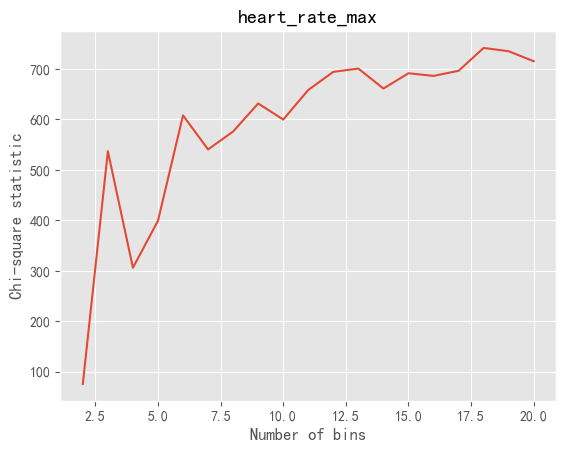

Number of bins: 2, Chi-square statistic: 399.5106810576794, p-value: 2.82582426613938e-86
Number of bins: 3, Chi-square statistic: 221.00973621614014, p-value: 6.337794403413082e-45
Number of bins: 4, Chi-square statistic: 426.7365191635788, p-value: 2.6841156405209065e-86
Number of bins: 5, Chi-square statistic: 404.96792545091455, p-value: 3.3566643700296106e-79
Number of bins: 6, Chi-square statistic: 493.4400824359582, p-value: 1.3790823100757966e-95
Number of bins: 7, Chi-square statistic: 492.7049891612847, p-value: 3.5619090560899063e-93
Number of bins: 8, Chi-square statistic: 521.5593470785484, p-value: 4.58291983576948e-97
Number of bins: 9, Chi-square statistic: 568.9141979900683, p-value: 7.446369239053612e-105
Number of bins: 10, Chi-square statistic: 538.0166076607783, p-value: 2.141400016597534e-96
Number of bins: 11, Chi-square statistic: 577.880247672506, p-value: 1.1150392163508862e-102
Number of bins: 12, Chi-square statistic: 587.59117469078, p-value: 9.315040248925

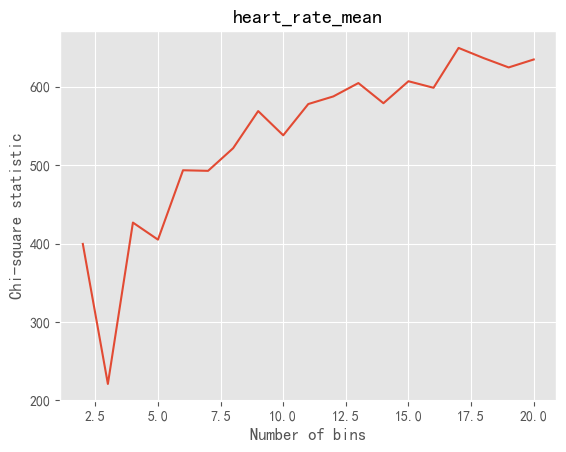

Number of bins: 2, Chi-square statistic: 140.58100318533965, p-value: 2.8325878318282284e-30
Number of bins: 3, Chi-square statistic: 156.07607857190663, p-value: 4.01071677843209e-31
Number of bins: 4, Chi-square statistic: 187.79712432159397, p-value: 1.1894610363224547e-35
Number of bins: 5, Chi-square statistic: 243.64342736335317, p-value: 2.890607066584381e-45
Number of bins: 6, Chi-square statistic: 247.14001687389316, p-value: 4.817198108533603e-44
Number of bins: 7, Chi-square statistic: 307.0002115546715, p-value: 1.7465604112014844e-54
Number of bins: 8, Chi-square statistic: 269.0169696837921, p-value: 6.081956381336264e-45
Number of bins: 9, Chi-square statistic: 279.7488127133141, p-value: 1.9524099688842187e-45
Number of bins: 10, Chi-square statistic: 289.0514079085093, p-value: 1.092557967669966e-45
Number of bins: 11, Chi-square statistic: 295.05186261028666, p-value: 2.494699334408384e-45
Number of bins: 12, Chi-square statistic: 293.5213868378736, p-value: 1.5066614

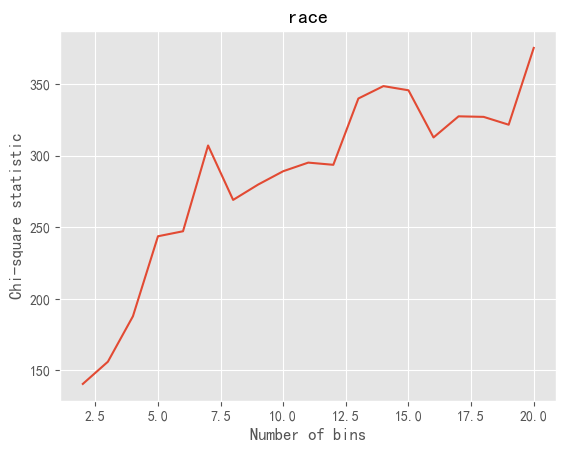

Number of bins: 2, Chi-square statistic: 1269.1591116277489, p-value: 7.238364786407984e-275
Number of bins: 3, Chi-square statistic: 1490.475522106208, p-value: 0.0
Number of bins: 4, Chi-square statistic: 1750.7279776253495, p-value: 0.0
Number of bins: 5, Chi-square statistic: 1864.700280395045, p-value: 0.0
Number of bins: 6, Chi-square statistic: 1853.9497036184912, p-value: 0.0
Number of bins: 7, Chi-square statistic: 1888.6471257206988, p-value: 0.0
Number of bins: 8, Chi-square statistic: 1919.409341845711, p-value: 0.0
Number of bins: 9, Chi-square statistic: 1917.1267574392405, p-value: 0.0
Number of bins: 10, Chi-square statistic: 1969.8365641093462, p-value: 0.0
Number of bins: 11, Chi-square statistic: 1966.9792972999874, p-value: 0.0
Number of bins: 12, Chi-square statistic: 1975.5761948736579, p-value: 0.0
Number of bins: 13, Chi-square statistic: 1981.8507827812869, p-value: 0.0
Number of bins: 14, Chi-square statistic: 1984.8843408445755, p-value: 0.0
Number of bins: 1

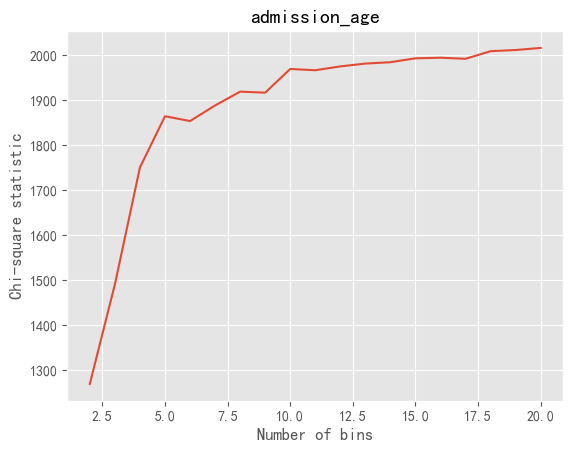

In [58]:
for col in cols:
    get_best_bin_qcut(train, col)

In [33]:
def get_onehot(train, test, feature_name):
    feature_bins = {
                    'ptt_min': 10,
                    'inr_max': 15,
                    'calcium_min.1': 9,
                    'temperature_mean': 10,
                    'glucose_min': 5,
                    'glucose_mean': 10,
                    'weight_admit': 15,
                    'aniongap_max': 6,
                    'aniongap_min': 12,
                    'potassium_min.1': 8,
                    'bicarbonate_max.1': 11,
                    'chloride_max.1': 10,
                    'gcs_verbal': 10,
                    'hemoglobin_min.1': 10,
                    'hematocrit_min.1': 10,
                    'bun_max': 15,
                    'gcs_eyes': 9,
                    'resp_rate_max': 9,
                    'resp_rate_min': 11,
                    'spo2_mean': 10,
                    'spo2_min': 12,
                    'dbp_min': 11,
                    'sbp_mean': 14,
                    'sbp_min': 13,
                    'heart_rate_max': 13,
                    'heart_rate_mean': 13,
                    'race': 14,
                    'admission_age': 10
                }
    # enc = KBinsDiscretizer(n_bins=feature_bins[feature_name], encode='onehot', strategy='uniform')
    # train_onehot_encoded = enc.fit_transform(train[feature_name].values.reshape(-1, 1))
    # train_onehot_encoded = pd.DataFrame(train_onehot_encoded.toarray(), index=train.index, columns=[f'{feature_name}_{i}' for i in range(feature_bins[feature_name])])
    # test_onehot_encoded = enc.transform(test[feature_name].values.reshape(-1, 1))
    # test_onehot_encoded = pd.DataFrame(test_onehot_encoded.toarray(), index=test.index, columns=[f'{feature_name}_{i}' for i in range(feature_bins[feature_name])])
    full_data = pd.concat([train[[feature_name]], test[[feature_name]]], axis=0)
    enc = KBinsDiscretizer(n_bins=feature_bins[feature_name], encode='ordinal', strategy='uniform')
    full_onehot_encoded = enc.fit_transform(full_data.values.reshape(-1, 1))
    full_onehot_encoded = pd.get_dummies(full_onehot_encoded.squeeze(), prefix=feature_name, drop_first=True)

    train_onehot_encoded = full_onehot_encoded[:train.shape[0]]
    test_onehot_encoded = full_onehot_encoded[train.shape[0]:]
    
    return train_onehot_encoded, test_onehot_encoded


In [34]:
train_onehot, test_onehot = get_onehot(train, test, 'ptt_min')

In [35]:
cols = ['ptt_min', 'inr_max', 'calcium_min.1', 'temperature_mean',
       'glucose_min', 'glucose_mean', 'weight_admit', 'aniongap_max',
       'aniongap_min', 'potassium_min.1', 'bicarbonate_max.1',
       'chloride_max.1', 'gcs_verbal', 'hemoglobin_min.1', 'hematocrit_min.1',
       'bun_max', 'gcs_eyes', 'resp_rate_max', 'resp_rate_min', 'spo2_mean',
       'spo2_min', 'dbp_min', 'sbp_mean', 'sbp_min', 'heart_rate_max',
       'heart_rate_mean', 'race', 'admission_age']
train_onehot = pd.DataFrame()
test_onehot = pd.DataFrame()
for col in cols:
    train_onehot_encoded, test_onehot_encoded = get_onehot(train, test, col)
    train_onehot = pd.concat([train_onehot, train_onehot_encoded], axis=1)
    test_onehot = pd.concat([test_onehot, test_onehot_encoded], axis=1)
    

In [36]:
train_onehot.index = train.index
test_onehot.index = test.index
train_onehot = pd.concat([train_onehot, train["aki"]], axis=1)
test_onehot = pd.concat([test_onehot, test["aki"]], axis=1)

In [37]:
train_onehot.head()

,ptt_min_1.0,ptt_min_2.0,ptt_min_3.0,ptt_min_4.0,ptt_min_5.0,ptt_min_6.0,ptt_min_7.0,ptt_min_8.0,ptt_min_9.0,inr_max_1.0,inr_max_2.0,inr_max_3.0,inr_max_4.0,inr_max_5.0,inr_max_6.0,inr_max_7.0,inr_max_8.0,inr_max_9.0,inr_max_10.0,inr_max_11.0,inr_max_13.0,inr_max_14.0,calcium_min.1_1.0,calcium_min.1_2.0,calcium_min.1_3.0,calcium_min.1_4.0,calcium_min.1_5.0,calcium_min.1_6.0,calcium_min.1_7.0,calcium_min.1_8.0,temperature_mean_1.0,temperature_mean_2.0,temperature_mean_3.0,temperature_mean_4.0,temperature_mean_5.0,temperature_mean_6.0,temperature_mean_7.0,temperature_mean_8.0,temperature_mean_9.0,glucose_min_4.0,glucose_mean_1.0,glucose_mean_2.0,glucose_mean_3.0,glucose_mean_5.0,glucose_mean_9.0,weight_admit_1.0,weight_admit_2.0,weight_admit_3.0,weight_admit_14.0,aniongap_max_1.0,aniongap_max_2.0,aniongap_max_3.0,aniongap_max_5.0,aniongap_min_1.0,aniongap_min_2.0,aniongap_min_3.0,aniongap_min_4.0,aniongap_min_5.0,aniongap_min_6.0,aniongap_min_7.0,aniongap_min_8.0,aniongap_min_9.0,aniongap_min_10.0,aniongap_min_11.0,potassium_min.1_1.0,potassium_min.1_2.0,potassium_min.1_3.0,potassium_min.1_4.0,potassium_min.1_5.0,potassium_min.1_6.0,potassium_min.1_7.0,bicarbonate_max.1_1.0,bicarbonate_max.1_2.0,bicarbonate_max.1_3.0,bicarbonate_max.1_4.0,bicarbonate_max.1_5.0,bicarbonate_max.1_6.0,bicarbonate_max.1_7.0,bicarbonate_max.1_8.0,bicarbonate_max.1_9.0,bicarbonate_max.1_10.0,chloride_max.1_1.0,chloride_max.1_2.0,chloride_max.1_3.0,chloride_max.1_4.0,chloride_max.1_5.0,chloride_max.1_6.0,chloride_max.1_7.0,chloride_max.1_8.0,chloride_max.1_9.0,gcs_verbal_2.0,gcs_verbal_4.0,gcs_verbal_5.0,gcs_verbal_6.0,gcs_verbal_7.0,gcs_verbal_8.0,gcs_verbal_9.0,hemoglobin_min.1_1.0,hemoglobin_min.1_2.0,hemoglobin_min.1_3.0,hemoglobin_min.1_4.0,hemoglobin_min.1_5.0,hemoglobin_min.1_6.0,hemoglobin_min.1_7.0,hemoglobin_min.1_8.0,hemoglobin_min.1_9.0,hematocrit_min.1_1.0,hematocrit_min.1_2.0,hematocrit_min.1_3.0,hematocrit_min.1_4.0,hematocrit_min.1_5.0,hematocrit_min.1_6.0,hematocrit_min.1_7.0,hematocrit_min.1_8.0,hematocrit_min.1_9.0,bun_max_1.0,bun_max_2.0,bun_max_3.0,bun_max_4.0,bun_max_5.0,bun_max_6.0,bun_max_7.0,bun_max_8.0,bun_max_9.0,bun_max_10.0,bun_max_11.0,bun_max_12.0,bun_max_13.0,bun_max_14.0,gcs_eyes_1.0,gcs_eyes_2.0,gcs_eyes_3.0,gcs_eyes_4.0,gcs_eyes_5.0,gcs_eyes_6.0,gcs_eyes_7.0,gcs_eyes_8.0,resp_rate_max_1.0,resp_rate_max_2.0,resp_rate_max_3.0,resp_rate_max_4.0,resp_rate_max_5.0,resp_rate_max_6.0,resp_rate_max_7.0,resp_rate_max_8.0,resp_rate_min_1.0,resp_rate_min_2.0,resp_rate_min_3.0,resp_rate_min_4.0,resp_rate_min_5.0,resp_rate_min_6.0,resp_rate_min_7.0,resp_rate_min_8.0,resp_rate_min_10.0,spo2_mean_1.0,spo2_mean_2.0,spo2_mean_3.0,spo2_mean_4.0,spo2_mean_5.0,spo2_mean_6.0,spo2_mean_7.0,spo2_mean_8.0,spo2_mean_9.0,spo2_min_1.0,spo2_min_2.0,spo2_min_3.0,spo2_min_4.0,spo2_min_5.0,spo2_min_6.0,spo2_min_7.0,spo2_min_8.0,spo2_min_9.0,spo2_min_10.0,spo2_min_11.0,dbp_min_1.0,dbp_min_2.0,dbp_min_3.0,dbp_min_4.0,dbp_min_5.0,dbp_min_6.0,dbp_min_7.0,dbp_min_8.0,dbp_min_9.0,dbp_min_10.0,sbp_mean_1.0,sbp_mean_2.0,sbp_mean_3.0,sbp_mean_4.0,sbp_mean_5.0,sbp_mean_6.0,sbp_mean_7.0,sbp_mean_8.0,sbp_mean_9.0,sbp_mean_10.0,sbp_mean_11.0,sbp_mean_12.0,sbp_mean_13.0,sbp_min_1.0,sbp_min_2.0,sbp_min_3.0,sbp_min_4.0,sbp_min_5.0,sbp_min_6.0,sbp_min_7.0,sbp_min_8.0,sbp_min_9.0,sbp_min_10.0,sbp_min_11.0,sbp_min_12.0,heart_rate_max_1.0,heart_rate_max_2.0,heart_rate_max_3.0,heart_rate_max_4.0,heart_rate_max_5.0,heart_rate_max_6.0,heart_rate_max_7.0,heart_rate_max_8.0,heart_rate_max_9.0,heart_rate_max_10.0,heart_rate_max_11.0,heart_rate_max_12.0,heart_rate_mean_1.0,heart_rate_mean_2.0,heart_rate_mean_3.0,heart_rate_mean_4.0,heart_rate_mean_5.0,heart_rate_mean_6.0,heart_rate_mean_7.0,heart_rate_mean_8.0,heart_rate_mean_9.0,heart_rate_mean_10.0,heart_rate_mean_11.0,heart_rate_mean_12.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_7.0,race_8.0,race_9.0,race_10.0,race_11.0,race_12.0,race_13.0,admission_age_1.0,admission_age_2.0,admission_age_3.0,admission_a

In [38]:
train_onehot.shape

(48374, 256)

In [39]:
test_onehot.shape

(2546, 256)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


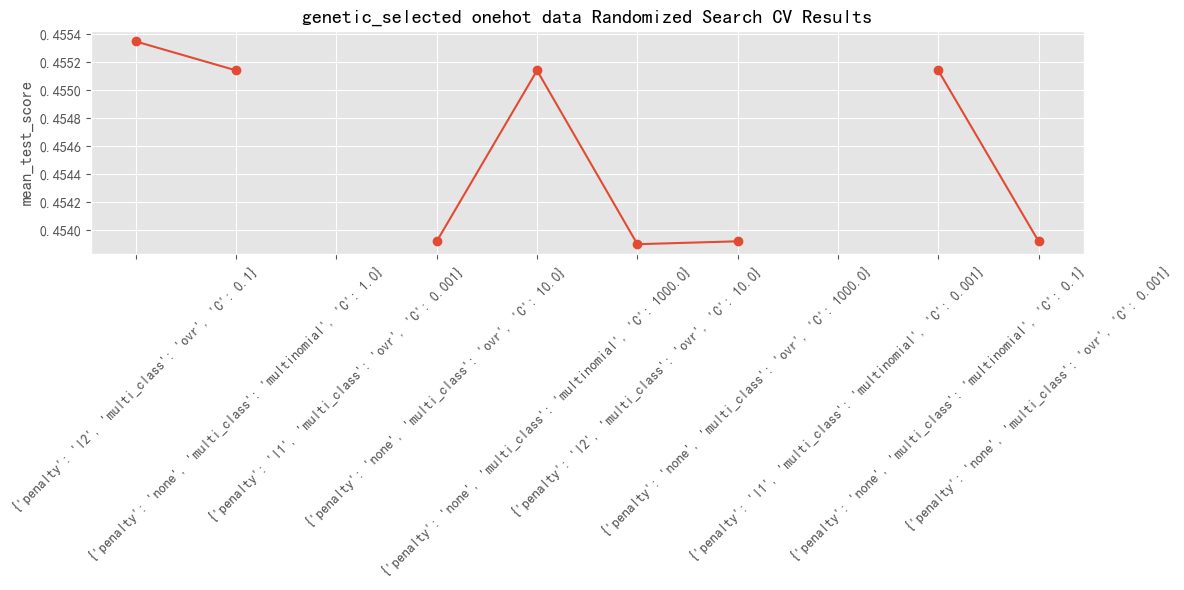

best_params: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.1}
best_score: 0.45534803375573407
genetic_selected onehot data最优模型在测试集上的表现:
Accuracy: 0.45286724273369994
              precision    recall  f1-score   support

         0.0       0.48      0.64      0.54       808
         1.0       0.00      0.00      0.00       461
         2.0       0.42      0.57      0.49       837
         3.0       0.49      0.36      0.41       440

    accuracy                           0.45      2546
   macro avg       0.35      0.39      0.36      2546
weighted avg       0.37      0.45      0.40      2546



In [43]:
search_hyperparameter_LR(train_onehot, test_onehot, "genetic_selected onehot data", {
            'C': np.logspace(-3, 3, 7),
            'penalty': ['none', 'l1', 'l2'],
            'multi_class': ['multinomial', 'ovr']
        })

In [44]:
def ttt(train, test, y_val):
    aa = train[train["aki"].isin(y_val)]
    bb = test[test["aki"].isin(y_val)]
    search_hyperparameter_LR(aa, bb, "genetic_selected onehot data", {
            'C': np.logspace(-3, 3, 7),
            'penalty': ['none', 'l1', 'l2'],
            'multi_class': ['multinomial', 'ovr']
        })

Fitting 5 folds for each of 10 candidates, totalling 50 fits


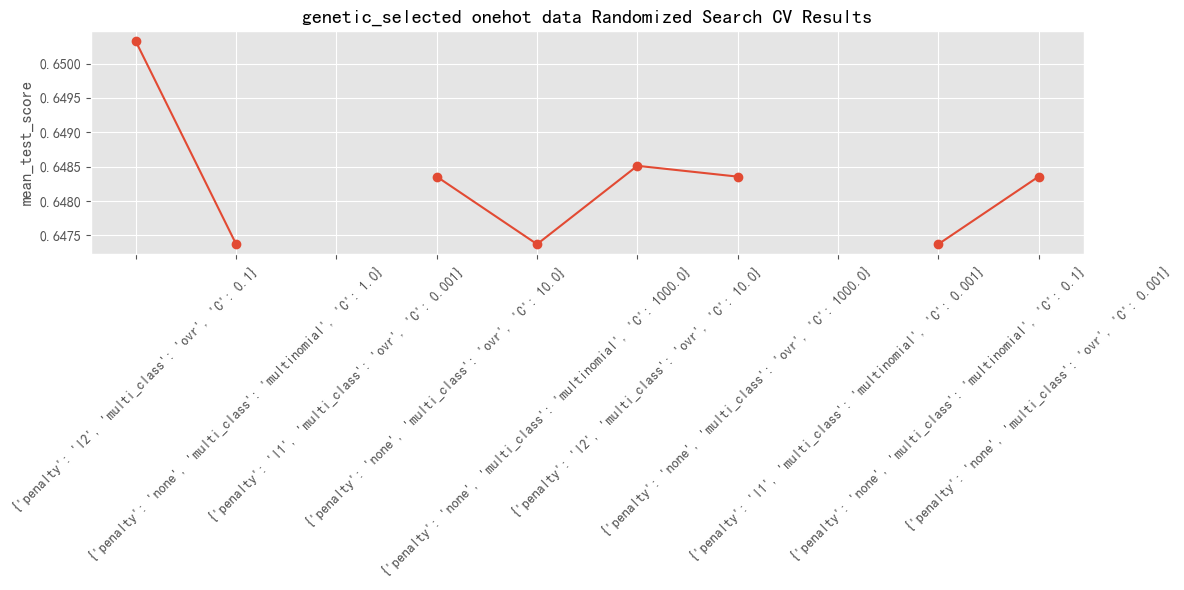

best_params: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.1}
best_score: 0.6503207022110555
genetic_selected onehot data最优模型在测试集上的表现:
Accuracy: 0.6422379826635146
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76       808
         1.0       0.52      0.23      0.32       461

    accuracy                           0.64      1269
   macro avg       0.59      0.55      0.54      1269
weighted avg       0.61      0.64      0.60      1269



In [45]:
ttt(train_onehot, test_onehot, [0,1])

In [50]:
test[['ptt_min', 'aki']].head()

,ptt_min,aki
id,,
36186843,19.1,0
31772481,47.3,0
39391355,20.0,0
35191106,30.4,2
39739359,31.7,0


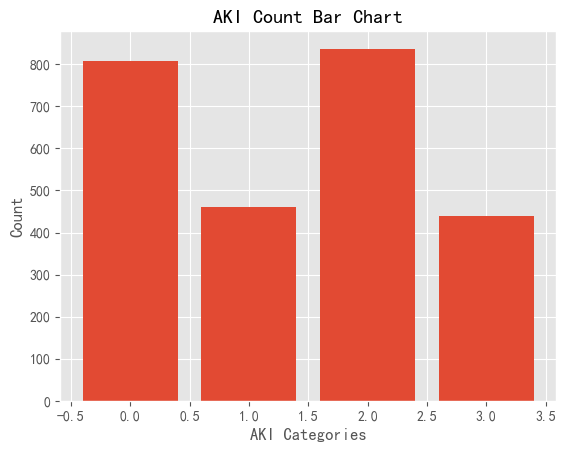

In [51]:
counts = test['aki'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('AKI Count Bar Chart')
plt.xlabel('AKI Categories')
plt.ylabel('Count')
plt.show()

## Adjust Parameters

### Draw parameters with the Accurancy 2D curve to select the appropriate interval

In [15]:
y_train = train_onehot['aki'].astype(float)
X_train = train_onehot.drop(['aki'], axis=1)
y_test = test_onehot['aki'].astype(float)
X_test = test_onehot.drop(['aki'], axis=1)

def train_model_get_accuracy(X_train, y_train, parameters): 
    rf = LogisticRegression(
        penalty = parameters['penalty'],
        C = parameters['C'],
        class_weight = parameters['class_weight'],
        multi_class = parameters['multi_class'],
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)
    return accuracy_score(y_test,rf.predict(X_test))

def search_hyperparameter(param_name, search_arr, plot_arr, X_train, y_train):
    parameters = {       
        'penalty':'l2',
        'C':1.0,
        'class_weight':None,
        'multi_class':'auto',
    }
    accurancyList = {
        'params':[],
        'precision':[]
    }
    for n in search_arr:
        parameters[param_name] = n
        accurancyList['params'].append(parameters)
        accurancyList['precision'].append(train_model_get_accuracy(X_train, y_train, parameters))

    plt.plot(plot_arr, accurancyList['precision'])
    plt.xlabel(param_name)
    plt.ylabel('accurancy')
    plt.title(f'Accurancy {param_name}')
    plt.show()

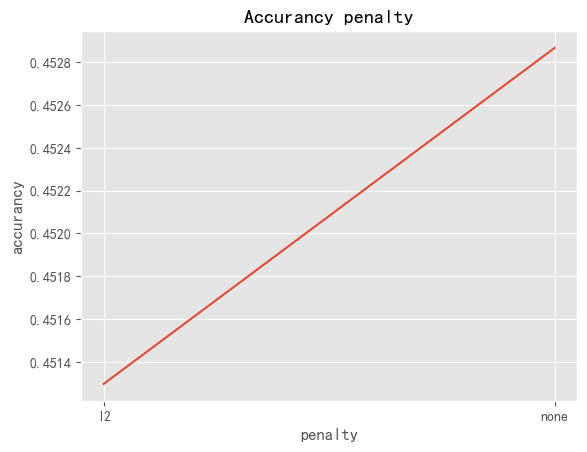

In [18]:
search_hyperparameter('penalty', 
                      ['l2', 'none'], 
                      ['l2', 'none'], 
                      X_train, 
                      y_train
                    )

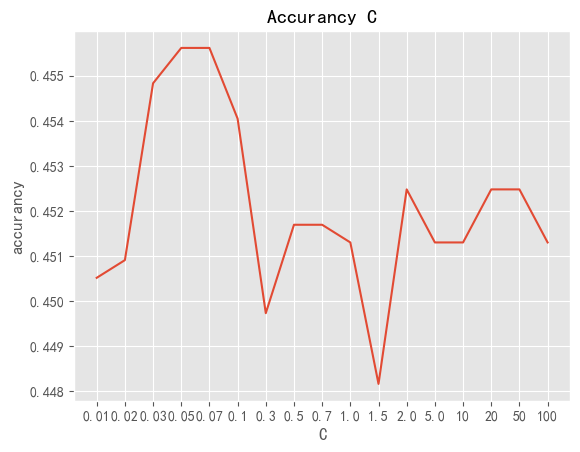

In [19]:
search_hyperparameter('C', 
                      [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10, 20, 50, 100], 
                      [str(i) for i in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10, 20, 50, 100]], 
                      X_train, 
                      y_train
                    )

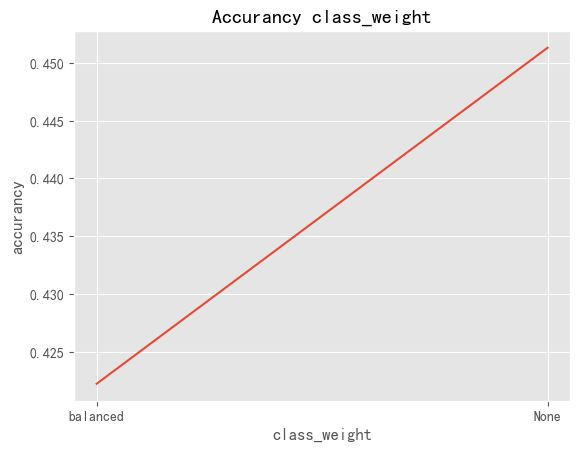

In [21]:
search_hyperparameter('class_weight', 
                      ['balanced', None], 
                      ['balanced', 'None'], 
                      X_train, 
                      y_train
                    )

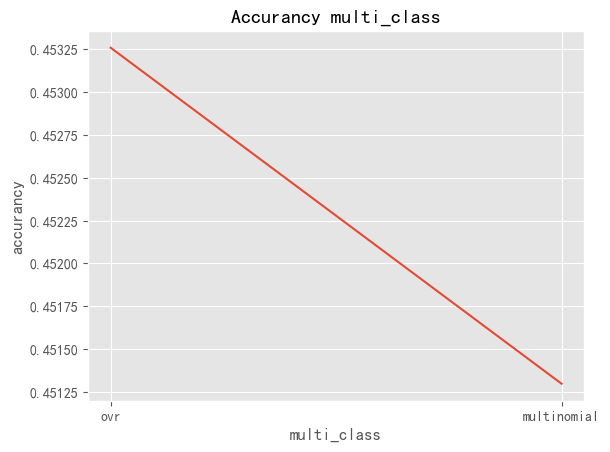

In [22]:
search_hyperparameter('multi_class', 
                      ['ovr', 'multinomial'], 
                      ['ovr', 'multinomial'], 
                      X_train, 
                      y_train
                    )

### RandomizedSearch

In [40]:
param_dist = {
    "penalty": ['l2', 'none'],
    "C": [*np.arange(0.03, 0.1, 0.01)],
    "class_weight": ['balanced', None],
    "multi_class": ['ovr', 'multinomial'],
}
model = LogisticRegression(n_jobs=-1, random_state=20)
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="accuracy", cv=5, n_iter=10)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("LogisticRegression AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'penalty': 'l2', 'multi_class': 'ovr', 'class_weight': None, 'C': 0.1}
best_score 0.45538938169867393
------------------------------------------------------------------
LogisticRegression AUC (Macro): 0.6706459620203269
              precision    recall  f1-score   support

         0.0       0.48      0.64      0.54       808
         1.0       0.00      0.00      0.00       461
         2.0       0.42      0.57      0.49       837
         3.0       0.49      0.36      0.41       440

    accuracy                           0.45      2546
   macro avg       0.35      0.39      0.36      2546
weighted avg       0.37      0.45      0.40      2546

------------------------------------------------------------------
train accuracy: 0.4608674081117956, test accuracy: 0.45286724273369994


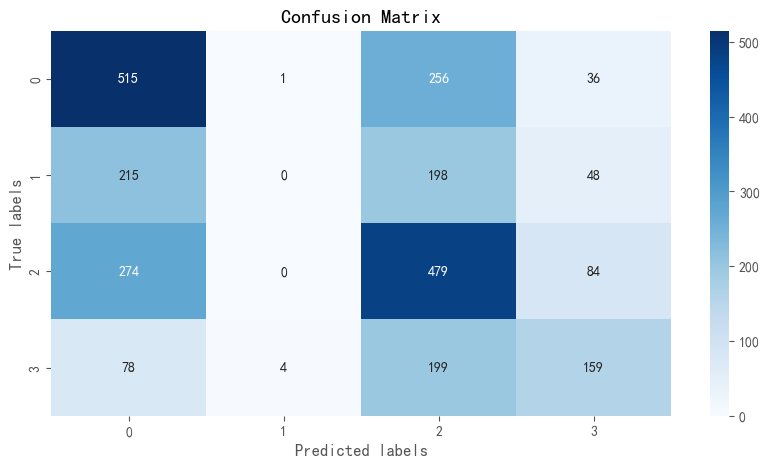

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()